In [2]:
import pandas as pd
import numpy as np
from skimpy import clean_columns
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from scipy.stats import tukey_hsd
from sklearn.metrics import r2_score
from scipy.stats import pearsonr



- [Guide for Generating PDFs](https://towardsdatascience.com/how-to-create-pdf-reports-with-python-the-essential-guide-c08dd3ebf2ee)  
- [Dynamic PDF Generation](https://advicement.io/dynamic-documents-api/documentation/getting-started)

### Climate Data

In [3]:
climate = pd.read_csv("Data/2023_scm_climate.csv")
climate = clean_columns(climate)
climate["date"] = pd.to_datetime(climate["date"], format="%m/%d/%y")
climate["week"] = climate["date"].dt.strftime("%U").astype(int)
climate


,record_id,longitude,latitude,elevation,date,rain_inches,min_temp_f,ave_temp_f,max_temp_f,mean_dew_point,vpd_min,vpd_max,week
0,POV_DUN,-76.3992,42.3875,1243,2023-01-01,0.02,36.5,43.8,51.1,42.8,0.14,2.87,1
1,POV_DUN,-76.3992,42.3875,1243,2023-01-02,0.00,36.6,39.4,42.2,32.9,0.93,3.12,1
2,POV_DUN,-76.3992,42.3875,1243,2023-01-03,0.00,29.1,38.5,47.9,34.0,0.08,4.35,1
3,POV_DUN,-76.3992,42.3875,1243,2023-01-04,0.51,38.2,45.6,53.0,44.9,0.06,1.44,1
4,POV_DUN,-76.3992,42.3875,1243,2023-01-05,0.21,37.0,46.9,56.7,46.7,0.13,3.47,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20435,ONE_STA,-74.6607,44.7711,468,2023-12-27,0.06,30.7,40.4,50.2,38.7,0.01,3.57,52
20436,ONE_STA,-74.6607,44.7711,468,2023-12-28,0.09,35.3,38.4,41.5,37.4,0.00,0.68,52
20437,ONE_STA,-74.6607,44.7711,468,2023-12-29,0.19,35.0,36.7,38.3,36.0,0.02,0.46,52
20438,ONE_STA,-74.6607,44.7711,468,2023-12-30,0.21,31.8,35.5,39.3,34.8,0.02,0.66,52


### Weekly Climate

In [4]:
weekly_climate = (
    climate[
        ["record_id", "week", "rain_inches", "min_temp_f", "ave_temp_f", "max_temp_f"]
    ]
    .groupby(["record_id", "week"])
    .mean()
)
weekly_climate = weekly_climate.reset_index()
weekly_climate = clean_columns(weekly_climate)
weekly_climate["next_week"] = weekly_climate["week"] + 1
weekly_climate


,record_id,week,rain_inches,min_temp_f,ave_temp_f,max_temp_f,next_week
0,DEG_DIE_HILL,1,0.155714,34.614286,41.071429,47.500000,2
1,DEG_DIE_HILL,2,0.112857,23.642857,29.357143,35.071429,3
2,DEG_DIE_HILL,3,0.180000,22.557143,27.500000,32.457143,4
3,DEG_DIE_HILL,4,0.112857,24.757143,28.814286,32.914286,5
4,DEG_DIE_HILL,5,0.018571,9.985714,18.957143,27.942857,6
...,...,...,...,...,...,...,...
2963,ZUE_REE,49,0.147143,32.142857,36.828571,41.500000,50
2964,ZUE_REE,50,0.041429,33.114286,39.442857,45.800000,51
2965,ZUE_REE,51,0.150000,27.757143,33.200000,38.628571,52
2966,ZUE_REE,52,0.161429,39.885714,43.557143,47.214286,53


### Landscape Data

In [6]:
landscape_500 = pd.read_csv("Landscape/cdl_five_year_history/2022/2023_scm_2022_cdl_500m.csv")
landscape_500["Prop_Corn"] = landscape_500["Corn"] / landscape_500["Total"]
landscape_500 = clean_columns(landscape_500).drop("unnamed_0", axis=1)
landscape_500


,name,corn,sorghum,soybeans,sweet_corn,barley,winter_wheat,rye,oats,speltz,...,semi_nat_prop,dev_prop,other_prop,corn_prop,soybean_prop,wheat_prop,forest_prop,total_nat_prop,buffer,prop_corn
0,POV_DUN,11,0,3,0,0,0,0,0,0,...,0.331234,0.086902,0.0,0.006927,0.001889,0.000000,0.456549,0.805416,500,0.006927
1,DIP_FLE,706,0,11,0,0,0,0,0,0,...,0.173425,0.055521,0.0,0.440424,0.006862,0.000000,0.162820,0.363693,500,0.440424
2,DIP_CUR,540,0,50,0,0,0,0,0,0,...,0.160075,0.089140,0.0,0.338983,0.031387,0.000000,0.130571,0.293158,500,0.338983
3,GAB_STE,252,0,0,0,0,0,0,0,0,...,0.129687,0.061463,0.0,0.154886,0.000000,0.000000,0.537800,0.691457,500,0.154886
4,SMI_CRO,712,0,344,0,0,1,178,16,0,...,0.104283,0.041589,0.0,0.441962,0.213532,0.000621,0.017381,0.122284,500,0.441962
5,SMI_CAN,217,0,13,0,0,0,0,0,0,...,0.190594,0.144802,0.0,0.134282,0.008045,0.000000,0.356436,0.594678,500,0.134282
6,SMI_KEL,98,0,179,0,0,0,0,0,0,...,0.078964,0.070944,0.0,0.060457,0.110426,0.000000,0.433066,0.517582,500,0.060457
7,SMI_COB,55,0,14,0,0,0,0,3,0,...,0.215442,0.241594,0.0,0.034247,0.008717,0.000000,0.181818,0.437111,500,0.034247
8,SMI_DOU,55,0,133,0,0,0,0,0,0,...,0.214769,0.094769,0.0,0.033846,0.081846,0.000000,0.107077,0.321846,500,0.033846
9,SMI_MCC,324,0,191,0,0,0,0,141,0,...,0.208487,0.051046,0.0,0.199262,0.117466,0.000000,0.059656,0.273063,500,0.199262


In [ ]:
landscape_1000 = pd.read_csv("Landscape/2023_scm_cdl_1000m.csv")
landscape_1000["Prop_Corn"] = landscape_1000["Corn"] / landscape_1000["Total"]
landscape_1000 = clean_columns(landscape_1000).drop("unnamed_0", axis=1)
landscape_1000


FileNotFoundError: [Errno 2] No such file or directory: 'Landscape/2023_scm_cdl_1000m.csv'

In [ ]:
landscape_2000 = pd.read_csv("Landscape/2023_scm_cdl_2000m.csv")
landscape_2000["Prop_Corn"] = landscape_2000["Corn"] / landscape_2000["Total"]
landscape_2000 = clean_columns(landscape_2000).drop("unnamed_0", axis=1)
landscape_2000


FileNotFoundError: [Errno 2] No such file or directory: 'Landscape/2023_scm_cdl_2000m.csv'

### Soil

In [ ]:
soil = pd.read_csv("Data/2023_scm_soil.csv")
soil = clean_columns(soil)
soil


,record_id,ny_soils_0,ny_soils_01,muid,hsg,hsgint,muserial,hsga,hsgb,hsgc,hsgd,hsgw
0,POV_DUN,2404,4346,NY134,A,1,6801,58,27,0,15,0
1,DIP_FLE,2190,4201,NY131,A,1,6798,0,14,63,23,0
2,DIP_CUR,2085,5669,NY134,A,1,6801,58,27,0,15,0
3,GAB_STE,1376,5311,NY084,A,1,6752,62,23,13,2,0
4,SMI_CRO,1779,5454,NY131,A,1,6798,0,14,63,23,0
5,SMI_CAN,1511,5436,NY128,B,2,6795,0,90,6,4,0
6,SMI_KEL,1659,5444,NY007,C,3,6681,0,40,48,12,0
7,SMI_COB,2029,3921,NY099,A,1,6767,54,28,6,12,0
8,SMI_DOU,1349,3760,NY007,C,3,6681,0,40,48,12,0
9,SMI_MCC,1401,3769,NY142,D,4,6809,0,34,31,35,0


### Management

In [7]:
management = pd.read_csv("Data/2023_management.csv")
management = clean_columns(management)
management


,field_id,previous_crop,cover_crop,manure,tillage
0,POV_DUN,Silage Corn,No,No,No Till
1,DIP_FLE,Silage Corn,Yes,No,No Till
2,DIP_CUR,Silage Corn,Yes,No,No Till
3,GAB_STE,Silage Corn,No,Yes,Till
4,SMI_CRO,Grain Corn,No,No,Till
5,SMI_CAN,Silage Corn,No,Yes,Till
6,SMI_KEL,Silage Corn,Yes,Yes,Till
7,SMI_COB,Silage Corn,Yes,No,No Till
8,SMI_DOU,Soybean,No,Yes,Till
9,SMI_MCC,Soybean,No,No,No Till


In [ ]:
management.groupby('cover_crop').count()['field_id']

cover_crop
No         28
Partial     2
Yes        24
Name: field_id, dtype: int64

In [ ]:
management.groupby('manure').count()['field_id']

manure
No     20
Yes    31
Name: field_id, dtype: int64

In [ ]:
management.groupby('previous_crop').count()['field_id']

previous_crop
Grain Corn                                 5
Mixed Veg                                  1
Silage Corn                               34
Silage Corn Strip Cropped With Alfalfa     1
Soybean                                    6
Sweet Corn                                 2
Wheat                                      2
Name: field_id, dtype: int64

### Planting Date

In [ ]:
planting_date = pd.read_csv("Data/2023_scm_planting_dates.csv")
planting_date = clean_columns(planting_date)
planting_date["planting_date"] = pd.to_datetime(
    planting_date["planting_date"], format="%m/%d/%y"
)
planting_date = planting_date.drop_duplicates("field_id")
planting_date["start_week"] = planting_date["planting_date"] - pd.Timedelta(7, unit="d")
planting_date


/var/folders/vt/gz9c8wh17772k93xq1vtnl0c0000gn/T/ipykernel_69061/3314138927.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  planting_date["start_week"] = planting_date["planting_date"] - pd.Timedelta(7, unit="d")


,field_id,planting_date,start_week
0,LET_TAB,2023-05-07,2023-04-30
2,GAB_ALL,2023-05-09,2023-05-02
4,SMI_CRO,2023-05-09,2023-05-02
6,SMI_DOU,2023-05-10,2023-05-03
8,DEG_PER_STRIP,2023-05-10,2023-05-03
10,DIP_PAT,2023-05-11,2023-05-04
12,KAT_TEE_2,2023-05-11,2023-05-04
16,KAT_TEE,2023-05-13,2023-05-06
18,SMI_COB,2023-05-13,2023-05-06
20,SMI_JOH,2023-05-13,2023-05-06


Average climate data for the week leading up to planting date, per site. 

In [ ]:
planting_temps = climate.merge(
    planting_date, left_on=["record_id"], right_on=["field_id"], how="left"
)
planting_temps = planting_temps.dropna()
planting_temps = planting_temps.loc[
    (planting_temps["date"] >= planting_temps["start_week"])
    & (planting_temps["date"] <= planting_temps["planting_date"])
]
planting_temps = planting_temps.drop(
    ["date", "week", "start_week", "longitude", "latitude", "elevation", "field_id"],
    axis=1,
)
planting_temps = planting_temps.groupby("record_id").mean()
# planting_temps.to_csv('Data/planting_date_climate.csv')
planting_temps


,rain_inches,min_temp_f,ave_temp_f,max_temp_f,planting_date
record_id,,,,,
DEG_FOU_WOOD,0.00000,36.7500,51.4625,66.1625,2023-05-18
DEG_PER_STRIP,0.08750,36.3250,46.5125,56.7250,2023-05-10
DEG_VIL,0.03375,39.4375,52.8500,66.2750,2023-05-15
DIP_CUR,0.00000,38.1875,51.7500,65.3000,2023-05-19
DIP_FLE,0.02875,41.7250,54.2750,66.7875,2023-05-23
DIP_PAT,0.04625,39.9625,50.8250,61.7000,2023-05-11
GAB_ALL,0.05000,43.2750,53.5625,63.8500,2023-05-09
GAB_STE,0.03125,43.7000,56.3750,69.0750,2023-05-23
KAT_BAR,0.02125,37.9125,53.3875,68.8625,2023-05-22


Average climate data for the week leading up to planting date, across all sites. 

In [ ]:
planting_temps.mean(numeric_only=True)


rain_inches     0.028468
min_temp_f     40.874597
ave_temp_f     53.856855
max_temp_f     66.839113
dtype: float64

Average climate data for the week leading up to planting date, per site for early planting dates (before 5/15).

In [ ]:
early_planting_temps = planting_temps.loc[
    planting_temps["planting_date"] <= "2023-05-15"
]
early_planting_temps


,rain_inches,min_temp_f,ave_temp_f,max_temp_f,planting_date
record_id,,,,,
DEG_PER_STRIP,0.08750,36.3250,46.5125,56.7250,2023-05-10
DEG_VIL,0.03375,39.4375,52.8500,66.2750,2023-05-15
DIP_PAT,0.04625,39.9625,50.8250,61.7000,2023-05-11
GAB_ALL,0.05000,43.2750,53.5625,63.8500,2023-05-09
KAT_TEE,0.01000,39.6375,54.0000,68.3250,2023-05-13
KAT_TEE_2,0.03750,37.1750,48.9375,60.6750,2023-05-11
LET_TAB,0.14500,37.1750,45.7375,54.3375,2023-05-07
ONE_STA,0.00750,42.2000,56.2500,70.3125,2023-05-15
SEA_HOO,0.02125,45.8875,57.6125,69.3000,2023-05-15


Average climate data for the week leading up to planting date, across all sites for early planting dates (before 5/15).

In [ ]:
early_planting_temps.mean(numeric_only=True)


rain_inches     0.044609
min_temp_f     40.720312
ave_temp_f     52.632031
max_temp_f     64.550000
dtype: float64

In [ ]:
early_planting_temps["range"] = (
    early_planting_temps["max_temp_f"] - early_planting_temps["min_temp_f"]
)
early_planting_temps


/var/folders/vt/gz9c8wh17772k93xq1vtnl0c0000gn/T/ipykernel_45936/3552099968.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  early_planting_temps["range"] = (


,rain_inches,min_temp_f,ave_temp_f,max_temp_f,planting_date,range
record_id,,,,,,
DEG_PER_STRIP,0.08750,36.3250,46.5125,56.7250,2023-05-10,20.4000
DEG_VIL,0.03375,39.4375,52.8500,66.2750,2023-05-15,26.8375
DIP_PAT,0.04625,39.9625,50.8250,61.7000,2023-05-11,21.7375
GAB_ALL,0.05000,43.2750,53.5625,63.8500,2023-05-09,20.5750
KAT_TEE,0.01000,39.6375,54.0000,68.3250,2023-05-13,28.6875
KAT_TEE_2,0.03750,37.1750,48.9375,60.6750,2023-05-11,23.5000
LET_TAB,0.14500,37.1750,45.7375,54.3375,2023-05-07,17.1625
ONE_STA,0.00750,42.2000,56.2500,70.3125,2023-05-15,28.1125
SEA_HOO,0.02125,45.8875,57.6125,69.3000,2023-05-15,23.4125


In [ ]:
np.mean(early_planting_temps["range"])


23.829687500000006

### Adult Abundance Count Data

In [8]:
scm_counts = pd.read_csv("Data/2023_scm_counts.csv")
scm_counts = clean_columns(scm_counts)
scm_counts["collection_date"] = pd.to_datetime(scm_counts["collection_date"], format="%m/%d/%y")
scm_counts["week"] = scm_counts["collection_date"].dt.strftime("%U")
#scm_counts = scm_counts.drop(['initials', 'notes'], axis=1)
#scm_counts = scm_counts.dropna()
scm_counts

,card_id,data_collector,site,collection_date,n_scm_i_m,n_scm_i_f,n_scm_o_m,n_scm_o_f,n_d_florilega_i,n_d_florilega_o,initials,notes,week
0,2001,Anna DiPaola,DIP_CUR,2023-03-13,NaN,NaN,NaN,NaN,NaN,NaN,YVH,NaN,11
1,2002,Anna DiPaola,DIP_CUR,2023-03-13,0.0,0.0,0.0,0.0,0.0,0.0,YVH,NaN,11
2,2003,Anna DiPaola,POV_DUN,2023-03-13,NaN,NaN,NaN,NaN,NaN,NaN,YVH,NaN,11
3,2004,Anna DiPaola,POV_DUN,2023-03-13,0.0,0.0,0.0,0.0,0.0,0.0,YVH,NaN,11
4,2005,Anna DiPaola,DIP_FLE,2023-03-13,NaN,NaN,NaN,NaN,NaN,NaN,YVH,NaN,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2401,7402,Alexa Stratton,DIP_CUR,2024-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01
2402,7403,Alexa Stratton,DIP_CUR,2023-01-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,03
2403,7404,Alexa Stratton,DIP_CUR,2023-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04
2404,7405,Kitty O'Neil,ONE_STA_1,2023-06-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24


### GDD Data

In [ ]:
gdd = pd.read_csv("Data/2023_scm_gdd.csv")
gdd = clean_columns(gdd)
gdd["date"] = pd.to_datetime(gdd["date"], format="%m/%d/%y")
gdd["week"] = gdd["date"].dt.strftime("%U").astype(int)
gdd


,record_id,date,temp_max_f,temp_min_f,temp_mean_f,gdd_fahrenheit_simple,gdd_fahrenheit_sine,gdd_fahrenheit_simple_cumsum,gdd_fahrenheit_sine_cum_sum,temp_max_c,temp_min_c,temp_mean_c,gdd_celsius_simple,gdd_celsius_sine,gdd_celsius_simple_cum_sum,gdd_celsius_sine_cum_sum,week
0,DEG_DIE_HILL,2023-01-01,51,37,44.0,5.0,5.327068,5.0,5.327068,10.555556,2.777778,6.666667,2.777778,2.959482,2.777778,2.959482,1
1,DEG_DIE_HILL,2023-01-02,42,36,39.0,0.0,0.955414,5.0,6.282482,5.555556,2.222222,3.888889,0.000000,0.530786,2.777778,3.490268,1
2,DEG_DIE_HILL,2023-01-03,47,32,39.5,0.5,2.643845,5.5,8.926327,8.333333,0.000000,4.166667,0.277778,1.468803,3.055556,4.959071,1
3,DEG_DIE_HILL,2023-01-04,53,37,45.0,6.0,6.305693,11.5,15.232020,11.666667,2.777778,7.222222,3.333333,3.503163,6.388889,8.462233,1
4,DEG_DIE_HILL,2023-01-05,56,38,47.0,8.0,8.102681,19.5,23.334701,13.333333,3.333333,8.333333,4.444444,4.501489,10.833333,12.963723,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10131,ZUE_REE,2023-06-26,82,66,74.0,35.0,35.000000,1589.5,1666.019274,27.777778,18.888889,23.333333,19.444444,19.444444,883.055556,925.566263,26
10132,ZUE_REE,2023-06-27,82,63,72.5,33.5,33.500000,1623.0,1699.519274,27.777778,17.222222,22.500000,18.611111,18.611111,901.666667,944.177374,26
10133,ZUE_REE,2023-06-28,80,60,70.0,31.0,31.000000,1654.0,1730.519274,26.666667,15.555556,21.111111,17.222222,17.222222,918.888889,961.399597,26
10134,ZUE_REE,2023-06-29,67,59,63.0,24.0,24.000000,1678.0,1754.519274,19.444444,15.000000,17.222222,13.333333,13.333333,932.222222,974.732930,26


### Germination Data

In [ ]:
germination = pd.read_csv('Data/2023_germination.csv')
germination = clean_columns(germination)
germination

,container_nr,date_collected,seed_type,date_1st_measure,nr_seeds_germinated_1st_measure,date_2nd_measure,nr_seeds_germinated_2nd_measure,nr_seeds_with_root_only,nr_seeds_with_shoot_only,nr_seeds_with_both_root_and_shoot,nr_seeds_not_germinated,dry_aboveground_biomass_of_seedlings,dry_belowground_biomass_of_seedlings
0,3013,4/18/23,corn,4/19/23,5,4/27/23,7.0,0.0,0.0,7.0,3.0,NaN,NaN
1,3014,4/18/23,lima,4/19/23,0,4/27/23,0.0,0.0,0.0,0.0,10.0,NaN,NaN
2,3015,4/18/23,lima,4/19/23,0,4/27/23,0.0,0.0,0.0,0.0,10.0,NaN,NaN
3,3016,4/18/23,corn,4/19/23,8,4/27/23,10.0,0.0,0.0,10.0,0.0,NaN,NaN
4,3017,4/18/23,corn,4/19/23,6,4/27/23,6.0,0.0,1.0,5.0,4.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,5138,6/27/23,corn,7/3/23,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
297,4783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.51086,0.74461
298,5014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.53330,0.07336
299,4043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.54062,0.35735


### Wire Mesh Data (Risk)

In [10]:
wire_mesh = pd.read_csv("Data/2023_wire_mesh.csv")
wire_mesh = clean_columns(wire_mesh)
wire_mesh["number_wireworm"] = (
    wire_mesh["number_wireworm"].replace(">10", 10).astype(float)
)
wire_mesh["total_phorid_maggots"] = (
    wire_mesh["total_phorid_maggots"].replace(">10", 10).astype(float)
)
wire_mesh["total_phorid_pupae"] = (
    wire_mesh["total_phorid_pupae"].replace(">10", 10).astype(float)
)

wire_mesh = wire_mesh.loc[wire_mesh['project'] == 'R']

wire_mesh

,id,container_number,project,seed_type,number_seeds,scm_seeds,other_seeds,total_scm_maggots,total_scm_pupae,number_wireworm,phorid_seeds,total_phorid_maggots,total_phorid_pupae,notes
4503,1,3011,R,Bean,8.0,1.0,2.0,1.0,2,0.0,1.0,1.0,1.0,NaN
4504,2,3011,R,Loose,NaN,NaN,NaN,0.0,0,0.0,NaN,1.0,2.0,NaN
4505,3,3011,R,Total,8.0,1.0,2.0,1.0,2,0.0,1.0,2.0,3.0,NaN
4506,4,3009,R,Corn,10.0,0.0,1.0,0.0,0,0.0,0.0,0.0,0.0,NaN
4507,5,3009,R,Loose,NaN,NaN,NaN,0.0,0,0.0,NaN,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5344,5432,5110,R,Loose,NaN,NaN,NaN,0.0,0,1.0,NaN,0.0,0.0,NaN
5345,5433,5110,R,Total,10.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,NaN
5346,5434,5112,R,Bean,10.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,NaN
5347,5435,5112,R,Loose,NaN,NaN,NaN,0.0,0,0.0,NaN,0.0,0.0,NaN


### Wire Mesh Intake

Contains mapping for container ID and field ID. 

In [11]:
wire_mesh_intake = pd.read_csv("Data/2023_wire_mesh_intake.csv")
wire_mesh_intake = clean_columns(wire_mesh_intake)
wire_mesh_intake = wire_mesh_intake.loc[wire_mesh_intake["project"] == "R"]
wire_mesh_intake


,container_number,container_type,project,record_id,collection_date,notes
1525,3003,deli cup,R,DIP_CUR,4/18/23,NaN
1526,3004,deli cup,R,DIP_CUR,4/18/23,NaN
1527,3015,sushi container,R,DIP_CUR,4/18/23,NaN
1528,3016,sushi container,R,DIP_CUR,4/18/23,NaN
1529,3229,sushi container,R,DIP_CUR,5/2/23,NaN
...,...,...,...,...,...,...
2106,3670,deli cup,R,ZUE_REE,5/9/23,NaN
2107,4279,sushi container,R,ZUE_REE,5/23/23,NaN
2108,4280,sushi container,R,ZUE_REE,5/23/23,NaN
2109,4281,deli cup,R,ZUE_REE,5/25/23,NaN


In [12]:
wire_mesh = wire_mesh.merge(
    wire_mesh_intake[
        ["container_number", "container_type", "collection_date", "record_id", 'project']
    ],
    on=["container_number", 'project'],
    how="left",
)
wire_mesh


,id,container_number,project,seed_type,number_seeds,scm_seeds,other_seeds,total_scm_maggots,total_scm_pupae,number_wireworm,phorid_seeds,total_phorid_maggots,total_phorid_pupae,notes,container_type,collection_date,record_id
0,1,3011,R,Bean,8.0,1.0,2.0,1.0,2,0.0,1.0,1.0,1.0,NaN,deli cup,4/17/23,GAB_ALL
1,2,3011,R,Loose,NaN,NaN,NaN,0.0,0,0.0,NaN,1.0,2.0,NaN,deli cup,4/17/23,GAB_ALL
2,3,3011,R,Total,8.0,1.0,2.0,1.0,2,0.0,1.0,2.0,3.0,NaN,deli cup,4/17/23,GAB_ALL
3,4,3009,R,Corn,10.0,0.0,1.0,0.0,0,0.0,0.0,0.0,0.0,NaN,deli cup,4/17/23,GAB_STE
4,5,3009,R,Loose,NaN,NaN,NaN,0.0,0,0.0,NaN,0.0,0.0,NaN,deli cup,4/17/23,GAB_STE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841,5432,5110,R,Loose,NaN,NaN,NaN,0.0,0,1.0,NaN,0.0,0.0,NaN,deli cup,6/12/23,SMI_CAN
842,5433,5110,R,Total,10.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0.0,NaN,deli cup,6/12/23,SMI_CAN
843,5434,5112,R,Bean,10.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,NaN,deli cup,6/14/23,SMI_HOF
844,5435,5112,R,Loose,NaN,NaN,NaN,0.0,0,0.0,NaN,0.0,0.0,NaN,deli cup,6/14/23,SMI_HOF


In [13]:
bean_containers = wire_mesh[wire_mesh["seed_type"] == "Bean"]
bean_containers = bean_containers["container_number"]
bean_containers


0      3011
6      3068
12     3010
18     3003
27     3042
       ... 
807    5117
813    5098
834    5034
837    4214
843    5112
Name: container_number, Length: 136, dtype: int64

In [14]:
corn_containers = wire_mesh[wire_mesh["seed_type"] == "Corn"]
corn_containers = corn_containers["container_number"]
corn_containers


3      3009
9      3067
15     3012
21     3005
24     3004
       ... 
822    5100
825    5114
828    5116
831    5033
840    5110
Name: container_number, Length: 146, dtype: int64

In [15]:
bean_data = wire_mesh[wire_mesh["container_number"].isin(bean_containers)]
bean_data = bean_data.loc[bean_data["seed_type"] == "Total"]
bean_data.loc[:, "seed_type"] = "Bean"
bean_data

,id,container_number,project,seed_type,number_seeds,scm_seeds,other_seeds,total_scm_maggots,total_scm_pupae,number_wireworm,phorid_seeds,total_phorid_maggots,total_phorid_pupae,notes,container_type,collection_date,record_id
2,3,3011,R,Bean,8.0,1.0,2.0,1.0,2,0.0,1.0,2.0,3.0,NaN,deli cup,4/17/23,GAB_ALL
8,9,3068,R,Bean,8.0,0.0,0.0,0.0,5,1.0,2.0,7.0,9.0,NaN,deli cup,4/18/23,SMI_JOH_2
14,15,3010,R,Bean,10.0,0.0,1.0,0.0,0,0.0,0.0,0.0,19.0,NaN,deli cup,4/17/23,GAB_STE
20,21,3003,R,Bean,5.0,0.0,1.0,0.0,17,0.0,0.0,0.0,0.0,NaN,deli cup,4/18/23,DIP_CUR
29,30,3042,R,Bean,10.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,NaN,deli cup,4/17/23,SMI_MCC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
809,5043,5117,R,Bean,10.0,0.0,2.0,0.0,0,0.0,0.0,0.0,0.0,NaN,deli cup,6/12/23,SMI_HOL
815,5049,5098,R,Bean,10.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,NaN,deli cup,6/9/23,MIL_CHA
836,5229,5034,R,Bean,10.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,NaN,deli cup,6/6/23,DIP_FLE
839,5403,4214,R,Bean,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,NaN,deli cup,5/19/23,WIS_KEN


In [16]:
corn_data = wire_mesh[wire_mesh["container_number"].isin(corn_containers)]
corn_data = corn_data.loc[corn_data["seed_type"] == "Total"]
corn_data.loc[:, "seed_type"] = "Corn"
corn_data


,id,container_number,project,seed_type,number_seeds,scm_seeds,other_seeds,total_scm_maggots,total_scm_pupae,number_wireworm,phorid_seeds,total_phorid_maggots,total_phorid_pupae,notes,container_type,collection_date,record_id
5,6,3009,R,Corn,10.0,0.0,1.0,0.0,0,0.0,0.0,0.0,0.0,NaN,deli cup,4/17/23,GAB_STE
11,12,3067,R,Corn,10.0,0.0,3.0,0.0,0,0.0,0.0,0.0,0.0,NaN,deli cup,4/18/23,SMI_JOH_2
17,18,3012,R,Corn,10.0,0.0,2.0,0.0,0,1.0,0.0,0.0,0.0,NaN,deli cup,4/17/23,GAB_ALL
23,24,3005,R,Corn,10.0,0.0,5.0,0.0,0,0.0,0.0,0.0,0.0,NaN,deli cup,4/18/23,DIP_PAT
26,27,3004,R,Corn,9.0,0.0,1.0,0.0,0,2.0,0.0,0.0,0.0,NaN,deli cup,4/18/23,DIP_CUR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824,5085,5100,R,Corn,10.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,NaN,deli cup,6/9/23,MIL_MCC
827,5097,5114,R,Corn,10.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,NaN,deli cup,6/12/23,SMI_KEL
830,5103,5116,R,Corn,10.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,NaN,deli cup,6/13/23,SMI_JOH_2
833,5184,5033,R,Corn,10.0,0.0,3.0,0.0,0,0.0,0.0,0.0,1.0,NaN,deli cup,6/6/23,DIP_FLE


In [17]:
wire_mesh = pd.concat([bean_data, corn_data], axis=0)
#wire_mesh = wire_mesh.loc[wire_mesh["project"] == "R"]
wire_mesh["collection_date"] = pd.to_datetime(
    wire_mesh["collection_date"], format="%m/%d/%y"
)
wire_mesh


,id,container_number,project,seed_type,number_seeds,scm_seeds,other_seeds,total_scm_maggots,total_scm_pupae,number_wireworm,phorid_seeds,total_phorid_maggots,total_phorid_pupae,notes,container_type,collection_date,record_id
2,3,3011,R,Bean,8.0,1.0,2.0,1.0,2,0.0,1.0,2.0,3.0,NaN,deli cup,2023-04-17,GAB_ALL
8,9,3068,R,Bean,8.0,0.0,0.0,0.0,5,1.0,2.0,7.0,9.0,NaN,deli cup,2023-04-18,SMI_JOH_2
14,15,3010,R,Bean,10.0,0.0,1.0,0.0,0,0.0,0.0,0.0,19.0,NaN,deli cup,2023-04-17,GAB_STE
20,21,3003,R,Bean,5.0,0.0,1.0,0.0,17,0.0,0.0,0.0,0.0,NaN,deli cup,2023-04-18,DIP_CUR
29,30,3042,R,Bean,10.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,NaN,deli cup,2023-04-17,SMI_MCC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824,5085,5100,R,Corn,10.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,NaN,deli cup,2023-06-09,MIL_MCC
827,5097,5114,R,Corn,10.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,NaN,deli cup,2023-06-12,SMI_KEL
830,5103,5116,R,Corn,10.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,NaN,deli cup,2023-06-13,SMI_JOH_2
833,5184,5033,R,Corn,10.0,0.0,3.0,0.0,0,0.0,0.0,0.0,1.0,NaN,deli cup,2023-06-06,DIP_FLE


In [18]:
wire_mesh = wire_mesh.merge(
    management, left_on="record_id", right_on="field_id", how="left"
)
wire_mesh


NameError: name 'management' is not defined

In [ ]:
wire_mesh = wire_mesh.merge(soil, on="record_id", how="left")
wire_mesh


NameError: name 'soil' is not defined

In [ ]:
wire_mesh["one_week"] = wire_mesh["collection_date"] - pd.Timedelta(7, unit="d")
wire_mesh["two_weeks"] = wire_mesh["collection_date"] - pd.Timedelta(14, unit="d")
wire_mesh


,id,container_number,project,seed_type,number_seeds,scm_seeds,other_seeds,total_scm_maggots,total_scm_pupae,number_wireworm,...,hsg,hsgint,muserial,hsga,hsgb,hsgc,hsgd,hsgw,one_week,two_weeks
0,3,3011,R,Bean,8.0,1.0,2.0,1.0,2,0.0,...,C,3.0,6805.0,0.0,11.0,63.0,26.0,0.0,2023-04-10,2023-04-03
1,9,3068,R,Bean,8.0,0.0,0.0,0.0,5,1.0,...,D,4.0,6809.0,0.0,34.0,31.0,35.0,0.0,2023-04-11,2023-04-04
2,15,3010,R,Bean,10.0,0.0,1.0,0.0,0,0.0,...,A,1.0,6752.0,62.0,23.0,13.0,2.0,0.0,2023-04-10,2023-04-03
3,21,3003,R,Bean,5.0,0.0,1.0,0.0,17,0.0,...,A,1.0,6801.0,58.0,27.0,0.0,15.0,0.0,2023-04-11,2023-04-04
4,30,3042,R,Bean,10.0,0.0,0.0,0.0,1,0.0,...,D,4.0,6809.0,0.0,34.0,31.0,35.0,0.0,2023-04-10,2023-04-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,5085,5100,R,Corn,10.0,0.0,0.0,0.0,0,0.0,...,B,2.0,6685.0,0.0,88.0,9.0,3.0,0.0,2023-06-02,2023-05-26
284,5097,5114,R,Corn,10.0,0.0,0.0,0.0,0,0.0,...,C,3.0,6681.0,0.0,40.0,48.0,12.0,0.0,2023-06-05,2023-05-29
285,5103,5116,R,Corn,10.0,0.0,0.0,0.0,0,0.0,...,D,4.0,6809.0,0.0,34.0,31.0,35.0,0.0,2023-06-06,2023-05-30
286,5184,5033,R,Corn,10.0,0.0,3.0,0.0,0,0.0,...,A,1.0,6798.0,0.0,14.0,63.0,23.0,0.0,2023-05-30,2023-05-23


In [ ]:
df = climate.merge(
    wire_mesh, left_on=["record_id"], right_on=["record_id"], how="left"
)[
    [
        "record_id",
        "date",
        "rain_inches",
        "min_temp_f",
        "ave_temp_f",
        "max_temp_f",
        "one_week",
        "two_weeks",
        "collection_date",
        'week'
    ]
]
df = df.dropna()
df = df.loc[(df['date'] >= df['one_week']) & (df['date'] <= df['collection_date'])].groupby(['record_id', 'collection_date'], as_index = False).mean(['rain_inches', 'min_temp_f', 'ave_temp_f', 'max_temp_f'])
df = df.rename(columns={"rain_inches": "rain_inches_one_week", "min_temp_f": "min_temp_f_one_week", "ave_temp_f": "ave_temp_f_one_week", "max_temp_f": "max_temp_f_one_week"})
df = df.drop(columns='week')
df

,record_id,collection_date,rain_inches_one_week,min_temp_f_one_week,ave_temp_f_one_week,max_temp_f_one_week
0,DIP_CUR,2023-04-18,0.09125,43.3125,57.0125,70.7500
1,DIP_CUR,2023-05-02,0.40000,36.7750,43.8125,50.8375
2,DIP_CUR,2023-05-16,0.00000,39.3625,52.4125,65.4500
3,DIP_CUR,2023-05-19,0.00000,38.1875,51.7500,65.3000
4,DIP_CUR,2023-06-02,0.00000,46.1000,60.9625,75.8250
...,...,...,...,...,...,...
140,WIS_MEG,2023-05-17,0.00000,44.4000,60.3625,76.3500
141,WIS_MEG,2023-06-02,0.00000,46.4375,62.9375,79.4875
142,ZUE_REE,2023-04-26,0.14375,38.5750,47.5625,56.5125
143,ZUE_REE,2023-05-09,0.09500,40.1125,48.7250,57.3250


In [ ]:
wire_mesh = wire_mesh.merge(df, left_on=['record_id', 'collection_date'], right_on=['record_id', 'collection_date'], how='left')
wire_mesh


,id,container_number,project,seed_type,number_seeds,scm_seeds,other_seeds,total_scm_maggots,total_scm_pupae,number_wireworm,...,hsgb,hsgc,hsgd,hsgw,one_week,two_weeks,rain_inches_one_week,min_temp_f_one_week,ave_temp_f_one_week,max_temp_f_one_week
0,3,3011,R,Bean,8.0,1.0,2.0,1.0,2,0.0,...,11.0,63.0,26.0,0.0,2023-04-10,2023-04-03,0.01000,48.5000,62.6875,76.9000
1,9,3068,R,Bean,8.0,0.0,0.0,0.0,5,1.0,...,34.0,31.0,35.0,0.0,2023-04-11,2023-04-04,0.04750,46.8125,61.1000,75.3875
2,15,3010,R,Bean,10.0,0.0,1.0,0.0,0,0.0,...,23.0,13.0,2.0,0.0,2023-04-10,2023-04-03,0.00250,47.0250,61.6500,76.2875
3,21,3003,R,Bean,5.0,0.0,1.0,0.0,17,0.0,...,27.0,0.0,15.0,0.0,2023-04-11,2023-04-04,0.09125,43.3125,57.0125,70.7500
4,30,3042,R,Bean,10.0,0.0,0.0,0.0,1,0.0,...,34.0,31.0,35.0,0.0,2023-04-10,2023-04-03,0.00875,41.3875,56.0375,70.7125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,5085,5100,R,Corn,10.0,0.0,0.0,0.0,0,0.0,...,88.0,9.0,3.0,0.0,2023-06-02,2023-05-26,0.07750,45.5375,58.8125,72.1000
284,5097,5114,R,Corn,10.0,0.0,0.0,0.0,0,0.0,...,40.0,48.0,12.0,0.0,2023-06-05,2023-05-29,0.03000,48.0750,58.5875,69.0875
285,5103,5116,R,Corn,10.0,0.0,0.0,0.0,0,0.0,...,34.0,31.0,35.0,0.0,2023-06-06,2023-05-30,0.18875,51.2625,60.9500,70.5750
286,5184,5033,R,Corn,10.0,0.0,3.0,0.0,0,0.0,...,14.0,63.0,23.0,0.0,2023-05-30,2023-05-23,0.00625,52.2875,65.9875,79.6875


In [ ]:
df = climate.merge(
    wire_mesh, left_on=["record_id"], right_on=["record_id"], how="left"
)[
    [
        "record_id",
        "date",
        "rain_inches",
        "min_temp_f",
        "ave_temp_f",
        "max_temp_f",
        "one_week",
        "two_weeks",
        "collection_date",
    ]
]
df = df.dropna()
df = df.loc[(df['date'] >= df['two_weeks']) & (df['date'] <= df['collection_date'])].groupby(['record_id', 'collection_date'], as_index = False).mean(['rain_inches', 'min_temp_f', 'ave_temp_f', 'max_temp_f'])
df = df.rename(columns={"rain_inches": "rain_inches_two_weeks", "min_temp_f": "min_temp_f_two_weeks", "ave_temp_f": "ave_temp_f_two_weeks", "max_temp_f": "max_temp_f_two_weeks"})
df

,record_id,collection_date,rain_inches_two_weeks,min_temp_f_two_weeks,ave_temp_f_two_weeks,max_temp_f_two_weeks
0,DIP_CUR,2023-04-18,0.120000,38.533333,50.920000,63.313333
1,DIP_CUR,2023-05-02,0.248667,37.460000,45.720000,54.000000
2,DIP_CUR,2023-05-16,0.034667,38.733333,49.573333,60.380000
3,DIP_CUR,2023-05-19,0.012000,37.853333,50.400000,62.926667
4,DIP_CUR,2023-06-02,0.006000,44.893333,58.526667,72.200000
...,...,...,...,...,...,...
140,WIS_MEG,2023-05-17,0.072000,43.346667,57.253333,71.186667
141,WIS_MEG,2023-06-02,0.040667,45.520000,60.560000,75.620000
142,ZUE_REE,2023-04-26,0.102667,43.733333,54.706667,65.686667
143,ZUE_REE,2023-05-09,0.166000,39.306667,47.486667,55.633333


In [ ]:
wire_mesh = wire_mesh.merge(df, left_on=['record_id', 'collection_date'], right_on=['record_id', 'collection_date'], how='left')
wire_mesh

NameError: name 'df' is not defined

In [ ]:
wire_mesh = wire_mesh.merge(gdd[['record_id', 'gdd_fahrenheit_simple_cumsum', 'gdd_fahrenheit_sine_cum_sum', 'date']], left_on=['record_id', 'collection_date'], right_on=['record_id', 'date'], how='left')
wire_mesh = wire_mesh.drop(columns='date')
wire_mesh

NameError: name 'gdd' is not defined

In [ ]:
wire_mesh["week"] = wire_mesh["collection_date"].dt.strftime("%U")
wire_mesh['week'] = wire_mesh['week'].astype('int')
wire_mesh

,id,container_number,project,seed_type,number_seeds,scm_seeds,other_seeds,total_scm_maggots,total_scm_pupae,number_wireworm,phorid_seeds,total_phorid_maggots,total_phorid_pupae,notes,container_type,collection_date,record_id,week
2,3,3011,R,Bean,8.0,1.0,2.0,1.0,2,0.0,1.0,2.0,3.0,NaN,deli cup,2023-04-17,GAB_ALL,16
8,9,3068,R,Bean,8.0,0.0,0.0,0.0,5,1.0,2.0,7.0,9.0,NaN,deli cup,2023-04-18,SMI_JOH_2,16
14,15,3010,R,Bean,10.0,0.0,1.0,0.0,0,0.0,0.0,0.0,19.0,NaN,deli cup,2023-04-17,GAB_STE,16
20,21,3003,R,Bean,5.0,0.0,1.0,0.0,17,0.0,0.0,0.0,0.0,NaN,deli cup,2023-04-18,DIP_CUR,16
29,30,3042,R,Bean,10.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,NaN,deli cup,2023-04-17,SMI_MCC,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824,5085,5100,R,Corn,10.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,NaN,deli cup,2023-06-09,MIL_MCC,23
827,5097,5114,R,Corn,10.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,NaN,deli cup,2023-06-12,SMI_KEL,24
830,5103,5116,R,Corn,10.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,NaN,deli cup,2023-06-13,SMI_JOH_2,24
833,5184,5033,R,Corn,10.0,0.0,3.0,0.0,0,0.0,0.0,0.0,1.0,NaN,deli cup,2023-06-06,DIP_FLE,23


In [ ]:
wire_mesh = wire_mesh.merge(scm_counts, left_on=['field_id', 'week'], right_on=['site', 'week'], how='left')
#wire_mesh = wire_mesh[wire_mesh['_merge'] == 'both']
#wire_mesh = wire_mesh.drop(columns=['date_y', '_merge'])
wire_mesh

KeyError: 'field_id'

In [ ]:
wire_mesh['last_week'] = wire_mesh['week'] - 1
wire_mesh

,id,container_number,project,seed_type,number_seeds,scm_seeds,other_seeds,total_scm_maggots,total_scm_pupae,number_wireworm,...,rain_inches_one_week,min_temp_f_one_week,ave_temp_f_one_week,max_temp_f_one_week,rain_inches_two_weeks,min_temp_f_two_weeks,ave_temp_f_two_weeks,max_temp_f_two_weeks,week,last_week
0,3,3011,R,Bean,8.0,1.0,2.0,1.0,2,0.0,...,0.01000,48.5000,62.6875,76.9000,0.036000,42.300000,54.346667,66.400000,16,15
1,9,3068,R,Bean,8.0,0.0,0.0,0.0,5,1.0,...,0.04750,46.8125,61.1000,75.3875,0.118000,40.886667,53.466667,66.046667,16,15
2,15,3010,R,Bean,10.0,0.0,1.0,0.0,0,0.0,...,0.00250,47.0250,61.6500,76.2875,0.039333,40.573333,53.080000,65.600000,16,15
3,21,3003,R,Bean,5.0,0.0,1.0,0.0,17,0.0,...,0.09125,43.3125,57.0125,70.7500,0.120000,38.533333,50.920000,63.313333,16,15
4,30,3042,R,Bean,10.0,0.0,0.0,0.0,1,0.0,...,0.00875,41.3875,56.0375,70.7125,0.140000,35.206667,47.866667,60.546667,16,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,5085,5100,R,Corn,10.0,0.0,0.0,0.0,0,0.0,...,0.07750,45.5375,58.8125,72.1000,0.041333,45.140000,59.613333,74.113333,23,22
284,5097,5114,R,Corn,10.0,0.0,0.0,0.0,0,0.0,...,0.03000,48.0750,58.5875,69.0875,0.068000,49.493333,62.820000,76.166667,24,23
285,5103,5116,R,Corn,10.0,0.0,0.0,0.0,0,0.0,...,0.18875,51.2625,60.9500,70.5750,0.100667,52.373333,64.440000,76.480000,24,23
286,5184,5033,R,Corn,10.0,0.0,3.0,0.0,0,0.0,...,0.00625,52.2875,65.9875,79.6875,0.003333,47.646667,61.553333,75.466667,23,22


In [ ]:
wire_mesh = wire_mesh.merge(scm_counts, left_on=['field_id', 'last_week'], right_on=['site', 'week'], how='left')
wire_mesh

KeyError: 'week'

In [ ]:
wire_mesh = wire_mesh.rename(columns={'n_scm_i_m_x' : 'n_scm_i_m_current', 'n_scm_i_f_x' : 'n_scm_i_f_current', 'n_scm_o_m_x' : 'n_scm_o_m_current', 'n_scm_o_f_x' : 'n_scm_o_f_current', 'n_d_florilega_i_x' : 'n_d_florilega_i_current', 'n_d_florilega_o_x' : 'n_d_florilega_o_current'})
wire_mesh

,id,container_number,project,seed_type,number_seeds,scm_seeds,other_seeds,total_scm_maggots,total_scm_pupae,number_wireworm,phorid_seeds,total_phorid_maggots,total_phorid_pupae,notes,container_type,collection_date,record_id
2,3,3011,R,Bean,8.0,1.0,2.0,1.0,2,0.0,1.0,2.0,3.0,NaN,deli cup,2023-04-17,GAB_ALL
8,9,3068,R,Bean,8.0,0.0,0.0,0.0,5,1.0,2.0,7.0,9.0,NaN,deli cup,2023-04-18,SMI_JOH_2
14,15,3010,R,Bean,10.0,0.0,1.0,0.0,0,0.0,0.0,0.0,19.0,NaN,deli cup,2023-04-17,GAB_STE
20,21,3003,R,Bean,5.0,0.0,1.0,0.0,17,0.0,0.0,0.0,0.0,NaN,deli cup,2023-04-18,DIP_CUR
29,30,3042,R,Bean,10.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,NaN,deli cup,2023-04-17,SMI_MCC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824,5085,5100,R,Corn,10.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,NaN,deli cup,2023-06-09,MIL_MCC
827,5097,5114,R,Corn,10.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,NaN,deli cup,2023-06-12,SMI_KEL
830,5103,5116,R,Corn,10.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,NaN,deli cup,2023-06-13,SMI_JOH_2
833,5184,5033,R,Corn,10.0,0.0,3.0,0.0,0,0.0,0.0,0.0,1.0,NaN,deli cup,2023-06-06,DIP_FLE


In [ ]:
wire_mesh = wire_mesh.rename(columns={'n_scm_i_m_y' : 'n_scm_i_m_2', 'n_scm_i_f_y' : 'n_scm_i_f_2', 'n_scm_o_m_y' : 'n_scm_o_m_2', 'n_scm_o_f_y' : 'n_scm_o_f_2', 'n_d_florilega_i_y' : 'n_d_florilega_i_2', 'n_d_florilega_o_y' : 'n_d_florilega_o_2'})
wire_mesh

,id,container_number,project,seed_type,number_seeds,scm_seeds,other_seeds,total_scm_maggots,total_scm_pupae,number_wireworm,...,rain_inches_one_week,min_temp_f_one_week,ave_temp_f_one_week,max_temp_f_one_week,rain_inches_two_weeks,min_temp_f_two_weeks,ave_temp_f_two_weeks,max_temp_f_two_weeks,week,last_week
0,3,3011,R,Bean,8.0,1.0,2.0,1.0,2,0.0,...,0.01000,48.5000,62.6875,76.9000,0.036000,42.300000,54.346667,66.400000,16,15
1,9,3068,R,Bean,8.0,0.0,0.0,0.0,5,1.0,...,0.04750,46.8125,61.1000,75.3875,0.118000,40.886667,53.466667,66.046667,16,15
2,15,3010,R,Bean,10.0,0.0,1.0,0.0,0,0.0,...,0.00250,47.0250,61.6500,76.2875,0.039333,40.573333,53.080000,65.600000,16,15
3,21,3003,R,Bean,5.0,0.0,1.0,0.0,17,0.0,...,0.09125,43.3125,57.0125,70.7500,0.120000,38.533333,50.920000,63.313333,16,15
4,30,3042,R,Bean,10.0,0.0,0.0,0.0,1,0.0,...,0.00875,41.3875,56.0375,70.7125,0.140000,35.206667,47.866667,60.546667,16,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,5085,5100,R,Corn,10.0,0.0,0.0,0.0,0,0.0,...,0.07750,45.5375,58.8125,72.1000,0.041333,45.140000,59.613333,74.113333,23,22
284,5097,5114,R,Corn,10.0,0.0,0.0,0.0,0,0.0,...,0.03000,48.0750,58.5875,69.0875,0.068000,49.493333,62.820000,76.166667,24,23
285,5103,5116,R,Corn,10.0,0.0,0.0,0.0,0,0.0,...,0.18875,51.2625,60.9500,70.5750,0.100667,52.373333,64.440000,76.480000,24,23
286,5184,5033,R,Corn,10.0,0.0,3.0,0.0,0,0.0,...,0.00625,52.2875,65.9875,79.6875,0.003333,47.646667,61.553333,75.466667,23,22


In [ ]:
wire_mesh = wire_mesh.drop(columns=['notes', 'field_id', 'week_y', 'card_id_y', 'data_collector_x', 'data_collector_y', 'site_x', 'site_y', 'date_x', 'date_y'])
wire_mesh = wire_mesh.rename(columns={'week_x' : 'week', 'card_id_x' : 'card_id'})
wire_mesh

KeyError: "['field_id', 'week_y', 'card_id_y', 'data_collector_x', 'data_collector_y', 'site_x', 'site_y', 'date_x', 'date_y'] not found in axis"

In [ ]:
wire_mesh = wire_mesh.merge(planting_date, left_on=['record_id'], right_on=['field_id'], how='left')
wire_mesh = wire_mesh.drop(columns = ['field_id', 'start_week'])
wire_mesh

KeyError: "['field_id'] not found in axis"

In [ ]:
wire_mesh.to_csv('Data/wire_mesh_features.csv')

In [ ]:
wire_mesh

,id,container_number,project,seed_type,number_seeds,scm_seeds,other_seeds,total_scm_maggots,total_scm_pupae,number_wireworm,phorid_seeds,total_phorid_maggots,total_phorid_pupae,notes,container_type,collection_date,record_id
2,3,3011,R,Bean,8.0,1.0,2.0,1.0,2,0.0,1.0,2.0,3.0,NaN,deli cup,2023-04-17,GAB_ALL
8,9,3068,R,Bean,8.0,0.0,0.0,0.0,5,1.0,2.0,7.0,9.0,NaN,deli cup,2023-04-18,SMI_JOH_2
14,15,3010,R,Bean,10.0,0.0,1.0,0.0,0,0.0,0.0,0.0,19.0,NaN,deli cup,2023-04-17,GAB_STE
20,21,3003,R,Bean,5.0,0.0,1.0,0.0,17,0.0,0.0,0.0,0.0,NaN,deli cup,2023-04-18,DIP_CUR
29,30,3042,R,Bean,10.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,NaN,deli cup,2023-04-17,SMI_MCC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824,5085,5100,R,Corn,10.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,NaN,deli cup,2023-06-09,MIL_MCC
827,5097,5114,R,Corn,10.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,NaN,deli cup,2023-06-12,SMI_KEL
830,5103,5116,R,Corn,10.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,NaN,deli cup,2023-06-13,SMI_JOH_2
833,5184,5033,R,Corn,10.0,0.0,3.0,0.0,0,0.0,0.0,0.0,1.0,NaN,deli cup,2023-06-06,DIP_FLE


# Risk Assessment Random Forest

In [ ]:
#wire_mesh = wire_mesh.dropna()
wire_mesh

,id,container_number,project,seed_type,number_seeds,scm_seeds,other_seeds,total_scm_maggots,total_scm_pupae,number_wireworm,...,max_temp_f_one_week,rain_inches_two_weeks,min_temp_f_two_weeks,ave_temp_f_two_weeks,max_temp_f_two_weeks,week,last_week,field_id_y,planting_date,start_week
0,3,3011,R,Bean,8.0,1.0,2.0,1.0,2,0.0,...,76.9000,0.036000,42.300000,54.346667,66.400000,16,15,GAB_ALL,2023-05-09,2023-05-02
1,9,3068,R,Bean,8.0,0.0,0.0,0.0,5,1.0,...,75.3875,0.118000,40.886667,53.466667,66.046667,16,15,NaN,NaT,NaT
2,15,3010,R,Bean,10.0,0.0,1.0,0.0,0,0.0,...,76.2875,0.039333,40.573333,53.080000,65.600000,16,15,GAB_STE,2023-05-23,2023-05-16
3,21,3003,R,Bean,5.0,0.0,1.0,0.0,17,0.0,...,70.7500,0.120000,38.533333,50.920000,63.313333,16,15,DIP_CUR,2023-05-19,2023-05-12
4,30,3042,R,Bean,10.0,0.0,0.0,0.0,1,0.0,...,70.7125,0.140000,35.206667,47.866667,60.546667,16,15,SMI_MCC,2023-05-15,2023-05-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,5085,5100,R,Corn,10.0,0.0,0.0,0.0,0,0.0,...,72.1000,0.041333,45.140000,59.613333,74.113333,23,22,NaN,NaT,NaT
284,5097,5114,R,Corn,10.0,0.0,0.0,0.0,0,0.0,...,69.0875,0.068000,49.493333,62.820000,76.166667,24,23,NaN,NaT,NaT
285,5103,5116,R,Corn,10.0,0.0,0.0,0.0,0,0.0,...,70.5750,0.100667,52.373333,64.440000,76.480000,24,23,NaN,NaT,NaT
286,5184,5033,R,Corn,10.0,0.0,3.0,0.0,0,0.0,...,79.6875,0.003333,47.646667,61.553333,75.466667,23,22,DIP_FLE,2023-05-23,2023-05-16


In [ ]:
wire_mesh_one_hot = pd.get_dummies(wire_mesh, columns = ['seed_type']) 
wire_mesh_one_hot

,id,container_number,project,number_seeds,scm_seeds,other_seeds,total_scm_maggots,total_scm_pupae,number_wireworm,phorid_seeds,...,min_temp_f_two_weeks,ave_temp_f_two_weeks,max_temp_f_two_weeks,week,last_week,field_id_y,planting_date,start_week,seed_type_Bean,seed_type_Corn
0,3,3011,R,8.0,1.0,2.0,1.0,2,0.0,1.0,...,42.300000,54.346667,66.400000,16,15,GAB_ALL,2023-05-09,2023-05-02,True,False
1,9,3068,R,8.0,0.0,0.0,0.0,5,1.0,2.0,...,40.886667,53.466667,66.046667,16,15,NaN,NaT,NaT,True,False
2,15,3010,R,10.0,0.0,1.0,0.0,0,0.0,0.0,...,40.573333,53.080000,65.600000,16,15,GAB_STE,2023-05-23,2023-05-16,True,False
3,21,3003,R,5.0,0.0,1.0,0.0,17,0.0,0.0,...,38.533333,50.920000,63.313333,16,15,DIP_CUR,2023-05-19,2023-05-12,True,False
4,30,3042,R,10.0,0.0,0.0,0.0,1,0.0,0.0,...,35.206667,47.866667,60.546667,16,15,SMI_MCC,2023-05-15,2023-05-08,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,5085,5100,R,10.0,0.0,0.0,0.0,0,0.0,0.0,...,45.140000,59.613333,74.113333,23,22,NaN,NaT,NaT,False,True
284,5097,5114,R,10.0,0.0,0.0,0.0,0,0.0,0.0,...,49.493333,62.820000,76.166667,24,23,NaN,NaT,NaT,False,True
285,5103,5116,R,10.0,0.0,0.0,0.0,0,0.0,0.0,...,52.373333,64.440000,76.480000,24,23,NaN,NaT,NaT,False,True
286,5184,5033,R,10.0,0.0,3.0,0.0,0,0.0,0.0,...,47.646667,61.553333,75.466667,23,22,DIP_FLE,2023-05-23,2023-05-16,False,True


In [ ]:
wire_mesh_one_hot.columns

Index(['id', 'container_number', 'project', 'number_seeds', 'scm_seeds',
       'other_seeds', 'total_scm_maggots', 'total_scm_pupae',
       'number_wireworm', 'phorid_seeds', 'total_phorid_maggots',
       'total_phorid_pupae', 'notes', 'container_type', 'collection_date',
       'record_id', 'field_id_x', 'previous_crop', 'cover_crop', 'manure',
       'ny_soils_0', 'ny_soils_01', 'muid', 'hsg', 'hsgint', 'muserial',
       'hsga', 'hsgb', 'hsgc', 'hsgd', 'hsgw', 'one_week', 'two_weeks',
       'rain_inches_one_week', 'min_temp_f_one_week', 'ave_temp_f_one_week',
       'max_temp_f_one_week', 'rain_inches_two_weeks', 'min_temp_f_two_weeks',
       'ave_temp_f_two_weeks', 'max_temp_f_two_weeks', 'week', 'last_week',
       'field_id_y', 'planting_date', 'start_week', 'seed_type_Bean',
       'seed_type_Corn'],
      dtype='object')

In [ ]:
X = wire_mesh_one_hot[
    [
        "seed_type_Bean",
        'seed_type_Corn',
        "collection_date",
        "record_id",
        "rain_inches_one_week",
        "min_temp_f_one_week",
        "ave_temp_f_one_week",
        "max_temp_f_one_week",
        "rain_inches_two_weeks",
        "min_temp_f_two_weeks",
        "ave_temp_f_two_weeks",
        "max_temp_f_two_weeks",
        "gdd_fahrenheit_simple_cumsum",
        "gdd_fahrenheit_sine_cum_sum",
        "planting_date",
    ]
]
y = wire_mesh["total_scm_maggots"]


KeyError: "['gdd_fahrenheit_simple_cumsum', 'gdd_fahrenheit_sine_cum_sum'] not in index"

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=44)
rf_model = RandomForestClassifier(n_estimators=50, max_features=None, random_state=44)
rf_model.fit(X_train, y_train)

NameError: name 'X' is not defined

# Adult Abundance

Farms with first emergence data - 

- DIP_CUR
- DIP_FLE
- POV_DUN
- GAB_STE

In [ ]:
first_emergence_farms = ["DIP_CUR", "DIP_FLE", "POV_DUN", "GAB_STE"]
first_emergence_farms


['DIP_CUR', 'DIP_FLE', 'POV_DUN', 'GAB_STE']

2023-04-23T00:00:00.000000000

%Y-%m-%dT%H:%M:%S.%f

In [ ]:
for farm in first_emergence_farms:
    count_tbl_name = farm + "_counts"
    gdd_tbl_name = farm + "_gdd"

    count_tbl_name = scm_counts[scm_counts["site"] == farm]
    gdd_tbl_name = gdd.loc[gdd["record_id"] == farm]

    pred_avg = gdd_tbl_name.loc[gdd_tbl_name["gdd_fahrenheit_simple_cumsum"] >= 296][
        "date"
    ].values[0]

    pred_sin = gdd_tbl_name.loc[gdd_tbl_name["gdd_fahrenheit_sine_cum_sum"] >= 361][
        "date"
    ].values[0]

    actual = count_tbl_name.loc[
        (count_tbl_name["n_scm_i_m"] >= 1)
        | (count_tbl_name["n_scm_o_m"] >= 1)
        | (count_tbl_name["n_scm_o_f"] >= 1)
        | (count_tbl_name["n_scm_o_f"] >= 1)
    ]["date"].values[0]

    print(
        "The actual first emergence date at " + farm + " is",
        datetime.strptime(str(actual), "%Y-%m-%dT%H:%M:%S.%f000").date(),
    )

    print(
        "The predicted first emergence date using the simple average model at "
        + farm
        + " is",
        datetime.strptime(str(pred_avg), "%Y-%m-%dT%H:%M:%S.%f000").date(),
    )
    print(
        "The predicted date using the simple average model was "
        + str(
            (
                datetime.strptime(str(pred_avg), "%Y-%m-%dT%H:%M:%S.%f000").date()
                - datetime.strptime(str(actual), "%Y-%m-%dT%H:%M:%S.%f000").date()
            ).days
        )
        + " days late"
    )

    print(
        "The predicted first emergence date using the sine wave model at "
        + farm
        + " is",
        datetime.strptime(str(pred_sin), "%Y-%m-%dT%H:%M:%S.%f000").date(),
    )
    print(
        "The predicted date using the sine wave model was "
        + str(
            (
                datetime.strptime(str(pred_sin), "%Y-%m-%dT%H:%M:%S.%f000").date()
                - datetime.strptime(str(actual), "%Y-%m-%dT%H:%M:%S.%f000").date()
            ).days
        )
        + " days late"
    )

    print(" ")


NameError: name 'gdd' is not defined

## New GDD Thresholds

Based on average cumulative GDD for four sites with first emergence dates. 

Week End (Collection Date)  

- DIP_CUR - 2023-04-06  
- DIP_FLE - 2023-03-28  
- POV_DUN - 2023-03-28  
- GAB_STE - 2023-03-28

Simple Average Model - GDD Average for Actual Emergence (Week End)

In [ ]:
np.mean([94, 63, 54, 59])

67.5

Sine Wave Model - GDD Average for Actual Emergence Date (Week End)

In [ ]:
np.mean([147, 119, 109, 131])

126.5

Week Start

- DIP_CUR - 2023-03-31  
- DIP_FLE - 2023-03-21  
- POV_DUN - 2023-03-21  
- GAB_STE - 2023-03-21

Simple Average Model - GDD Average for Actual Emergence (Week Start)

In [ ]:
np.mean([47, 46, 39, 40])


43.0

Sine Wave Model - GDD Average for Actual Emergence (Week Start)

In [ ]:
np.mean([93, 88, 80, 96])


89.25

Simple Average Model - GDD Average for Actual Emergence (Week Average)

In [ ]:
gdd.loc[(gdd['record_id'] == 'DIP_CUR') & (gdd['date'] >= '2023-03-31') & (gdd['date'] <= '2023-04-06')][['gdd_fahrenheit_simple_cumsum', 'gdd_fahrenheit_sine_cum_sum']].mean()
gdd.loc[(gdd['record_id'] == 'DIP_FLE') & (gdd['date'] >= '2023-03-21') & (gdd['date'] <= '2023-03-28')][['gdd_fahrenheit_simple_cumsum', 'gdd_fahrenheit_sine_cum_sum']].mean()
gdd.loc[(gdd['record_id'] == 'POV_DUN') & (gdd['date'] >= '2023-03-21') & (gdd['date'] <= '2023-03-28')][['gdd_fahrenheit_simple_cumsum', 'gdd_fahrenheit_sine_cum_sum']].mean()
gdd.loc[(gdd['record_id'] == 'GAB_STE') & (gdd['date'] >= '2023-03-21') & (gdd['date'] <= '2023-03-28')][['gdd_fahrenheit_simple_cumsum', 'gdd_fahrenheit_sine_cum_sum']].mean()

NameError: name 'gdd' is not defined

In [ ]:
np.mean([62, 58, 50, 51])


55.25

Sine Wave Model - GDD Average for Actual Emergence (Week Average)

In [ ]:
np.mean([113, 106, 98, 116])


108.25

In [ ]:
for farm in first_emergence_farms:
    count_tbl_name = farm + "_counts"
    gdd_tbl_name = farm + "_gdd"

    count_tbl_name = scm_counts[scm_counts["site"] == farm]
    gdd_tbl_name = gdd.loc[gdd["record_id"] == farm]

    pred_avg = gdd_tbl_name.loc[gdd_tbl_name["gdd_fahrenheit_simple_cumsum"] >= 67][
        "date"
    ].values[0]

    pred_sin = gdd_tbl_name.loc[gdd_tbl_name["gdd_fahrenheit_sine_cum_sum"] >= 127][
        "date"
    ].values[0]

    actual = count_tbl_name.loc[
        (count_tbl_name["n_scm_i_m"] >= 1)
        | (count_tbl_name["n_scm_o_m"] >= 1)
        | (count_tbl_name["n_scm_o_f"] >= 1)
        | (count_tbl_name["n_scm_o_f"] >= 1)
    ]["date"].values[0]

    print(
        "The actual first emergence date at " + farm + " is",
        datetime.strptime(str(actual), "%Y-%m-%dT%H:%M:%S.%f000").date(),
    )

    print(
        "The predicted first emergence date using the simple average model at "
        + farm
        + " is",
        datetime.strptime(str(pred_avg), "%Y-%m-%dT%H:%M:%S.%f000").date(),
    )
    print(
        "The predicted date using the simple average model was "
        + str(
            (
                datetime.strptime(str(pred_avg), "%Y-%m-%dT%H:%M:%S.%f000").date()
                - datetime.strptime(str(actual), "%Y-%m-%dT%H:%M:%S.%f000").date()
            ).days
        )
        + " days late"
    )

    print(
        "The predicted first emergence date using the sine wave model at "
        + farm
        + " is",
        datetime.strptime(str(pred_sin), "%Y-%m-%dT%H:%M:%S.%f000").date(),
    )
    print(
        "The predicted date using the sine wave model was "
        + str(
            (
                datetime.strptime(str(pred_sin), "%Y-%m-%dT%H:%M:%S.%f000").date()
                - datetime.strptime(str(actual), "%Y-%m-%dT%H:%M:%S.%f000").date()
            ).days
        )
        + " days late"
    )

    print(" ")


NameError: name 'gdd' is not defined

### K-W for SCM Abundance and Risk

In [ ]:
management = management.dropna()
management.head()

,field_id,previous_crop,cover_crop,manure
0,POV_DUN,Silage Corn,No,No
1,DIP_FLE,Silage Corn,Yes,No
2,DIP_CUR,Silage Corn,Yes,No
3,GAB_STE,Silage Corn,No,Yes
4,SMI_CRO,Grain Corn,No,No


In [ ]:
management.loc[management['previous_crop'].str.contains('corn', case=False), 'previous_crop'] = 'Corn'
crop_scm_count = management.merge(scm_counts, left_on='field_id', right_on='site', how='left')
crop_scm_count['n_scm'] = crop_scm_count['n_scm_i_m'] + crop_scm_count['n_scm_i_f'] + crop_scm_count['n_scm_o_m'] + crop_scm_count['n_scm_o_f']
crop_scm_count['f_scm'] = crop_scm_count['n_scm_i_f'] + crop_scm_count['n_scm_o_f']
crop_scm_count['m_scm'] = crop_scm_count['n_scm_i_m'] + crop_scm_count['n_scm_o_m'] 
crop_scm_count

/var/folders/vt/gz9c8wh17772k93xq1vtnl0c0000gn/T/ipykernel_45936/2569451698.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  management.loc[management['previous_crop'].str.contains('corn', case=False), 'previous_crop'] = 'Corn'


,field_id,previous_crop,cover_crop,manure,card_id,data_collector,site,collection_date,n_scm_i_m,n_scm_i_f,n_scm_o_m,n_scm_o_f,n_d_florilega_i,n_d_florilega_o,initials,n_scm,f_scm,m_scm
0,POV_DUN,Corn,No,No,2003,Anna DiPaola,POV_DUN,3/13/23,0.0,0.0,0.0,0.0,0.0,0.0,YVH,0.0,0.0,0.0
1,POV_DUN,Corn,No,No,2004,Anna DiPaola,POV_DUN,3/13/23,0.0,0.0,0.0,0.0,0.0,0.0,YVH,0.0,0.0,0.0
2,POV_DUN,Corn,No,No,2011,Shea Crowther,POV_DUN,3/21/23,0.0,0.0,0.0,0.0,0.0,0.0,YVH,0.0,0.0,0.0
3,POV_DUN,Corn,No,No,2012,Shea Crowther,POV_DUN,3/21/23,0.0,0.0,0.0,0.0,0.0,0.0,YVH,0.0,0.0,0.0
4,POV_DUN,Corn,No,No,2015,Shea Crowther,POV_DUN,3/28/23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1484,ONE_STA,Corn,No,Yes,6685,Kitty O'Neil,ONE_STA,8/8/23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1485,ONE_STA,Corn,No,Yes,6686,Kitty O'Neil,ONE_STA,8/14/23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1486,ONE_STA,Corn,No,Yes,6687,Kitty O'Neil,ONE_STA,8/14/23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1487,ONE_STA,Corn,No,Yes,6688,Kitty O'Neil,ONE_STA,8/21/23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


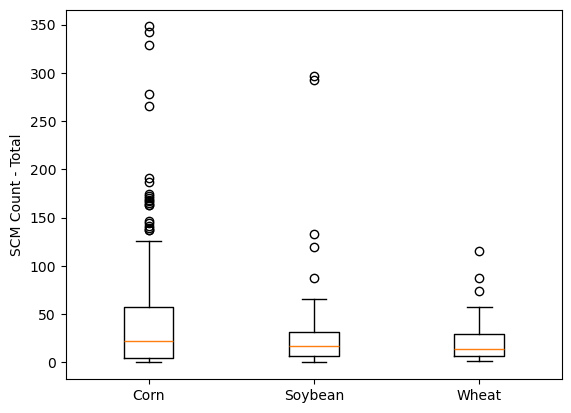

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.boxplot([crop_scm_count.loc[crop_scm_count["previous_crop"] == "Corn"]["n_scm"].dropna(),
    crop_scm_count.loc[crop_scm_count["previous_crop"] == "Soybean"]["n_scm"].dropna(),
    crop_scm_count.loc[crop_scm_count["previous_crop"] == "Wheat"]["n_scm"].dropna()])
ax.set_xticklabels(["Corn", "Soybean", "Wheat"]) 
ax.set_ylabel("SCM Count - Total") 
plt.show()

In [ ]:
stats.kruskal(
    crop_scm_count.loc[crop_scm_count["previous_crop"] == "Corn"]["n_scm"].dropna(),
    crop_scm_count.loc[crop_scm_count["previous_crop"] == "Soybean"]["n_scm"].dropna(),
    crop_scm_count.loc[crop_scm_count["previous_crop"] == "Wheat"]["n_scm"].dropna(),
)

KruskalResult(statistic=1.239330818676833, pvalue=0.5381244588949881)

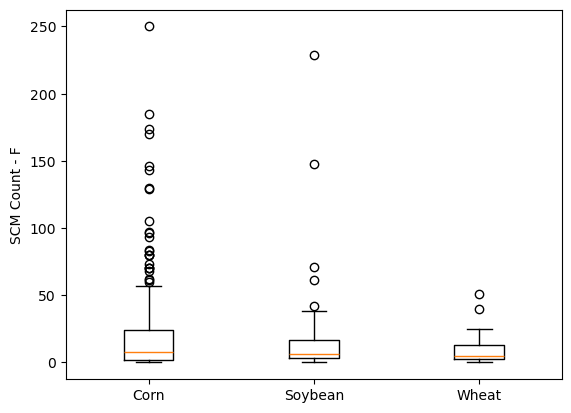

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.boxplot([crop_scm_count.loc[crop_scm_count["previous_crop"] == "Corn"]["f_scm"].dropna(),
    crop_scm_count.loc[crop_scm_count["previous_crop"] == "Soybean"]["f_scm"].dropna(),
    crop_scm_count.loc[crop_scm_count["previous_crop"] == "Wheat"]["f_scm"].dropna()])
ax.set_xticklabels(["Corn", "Soybean", "Wheat"]) 
ax.set_ylabel("SCM Count - F") 
plt.show()

In [ ]:
stats.kruskal(
    crop_scm_count.loc[crop_scm_count["previous_crop"] == "Corn"]["f_scm"].dropna(),
    crop_scm_count.loc[crop_scm_count["previous_crop"] == "Soybean"]["f_scm"].dropna(),
    crop_scm_count.loc[crop_scm_count["previous_crop"] == "Wheat"]["f_scm"].dropna(),
)

KruskalResult(statistic=0.7511429165991551, pvalue=0.6868966338291929)

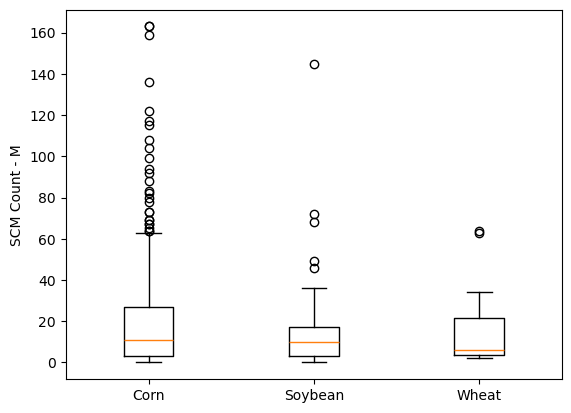

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.boxplot([crop_scm_count.loc[crop_scm_count["previous_crop"] == "Corn"]["m_scm"].dropna(),
    crop_scm_count.loc[crop_scm_count["previous_crop"] == "Soybean"]["m_scm"].dropna(),
    crop_scm_count.loc[crop_scm_count["previous_crop"] == "Wheat"]["m_scm"].dropna()])
ax.set_xticklabels(["Corn", "Soybean", "Wheat"]) 
ax.set_ylabel("SCM Count - M") 
plt.show()

In [ ]:
stats.kruskal(
    crop_scm_count.loc[crop_scm_count["previous_crop"] == "Corn"]["m_scm"].dropna(),
    crop_scm_count.loc[crop_scm_count["previous_crop"] == "Soybean"]["m_scm"].dropna(),
    crop_scm_count.loc[crop_scm_count["previous_crop"] == "Wheat"]["m_scm"].dropna(),
)

KruskalResult(statistic=0.9148504551879578, pvalue=0.6329111515474486)

In [ ]:
wire_mesh_previous_crop = wire_mesh[
    [
        "previous_crop",
        "scm_seeds",
        "other_seeds",
        "total_scm_maggots",
        "total_scm_pupae",
        "number_wireworm",
        "phorid_seeds",
        "total_phorid_maggots",
        "total_phorid_pupae",
    ]
]
wire_mesh_previous_crop = wire_mesh_previous_crop.dropna()

wire_mesh_previous_crop.loc[
    wire_mesh_previous_crop["previous_crop"].str.contains("corn", case=False),
    "previous_crop",
] = "Corn"

wire_mesh_previous_crop


,previous_crop,scm_seeds,other_seeds,total_scm_maggots,total_scm_pupae,number_wireworm,phorid_seeds,total_phorid_maggots,total_phorid_pupae
0,Corn,1.0,2.0,1.0,2,0.0,1.0,2.0,3.0
1,Wheat,0.0,0.0,0.0,5,1.0,2.0,7.0,9.0
2,Corn,0.0,1.0,0.0,0,0.0,0.0,0.0,19.0
3,Corn,0.0,1.0,0.0,17,0.0,0.0,0.0,0.0
4,Soybean,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
283,Soybean,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
284,Corn,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
285,Wheat,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0
286,Corn,0.0,3.0,0.0,0,0.0,0.0,0.0,1.0


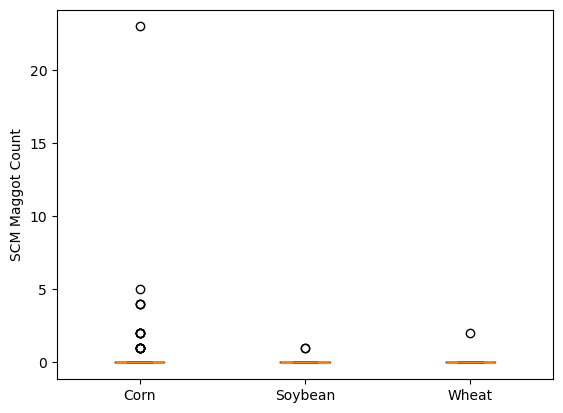

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.boxplot([wire_mesh_previous_crop.loc[wire_mesh_previous_crop["previous_crop"] == "Corn"]["total_scm_maggots"].dropna(),
    wire_mesh_previous_crop.loc[wire_mesh_previous_crop["previous_crop"] == "Soybean"]["total_scm_maggots"].dropna(),
    wire_mesh_previous_crop.loc[wire_mesh_previous_crop["previous_crop"] == "Wheat"]["total_scm_maggots"].dropna()])
ax.set_xticklabels(["Corn", "Soybean", "Wheat"]) 
ax.set_ylabel("SCM Maggot Count") 
plt.show()

In [ ]:
stats.kruskal(
    wire_mesh_previous_crop.loc[wire_mesh_previous_crop["previous_crop"] == "Corn"]["total_scm_maggots"].dropna(),
    wire_mesh_previous_crop.loc[wire_mesh_previous_crop["previous_crop"] == "Soybean"]["total_scm_maggots"].dropna(),
    wire_mesh_previous_crop.loc[wire_mesh_previous_crop["previous_crop"] == "Wheat"]["total_scm_maggots"].dropna(),
)

KruskalResult(statistic=0.4666633394098138, pvalue=0.7918908837478706)

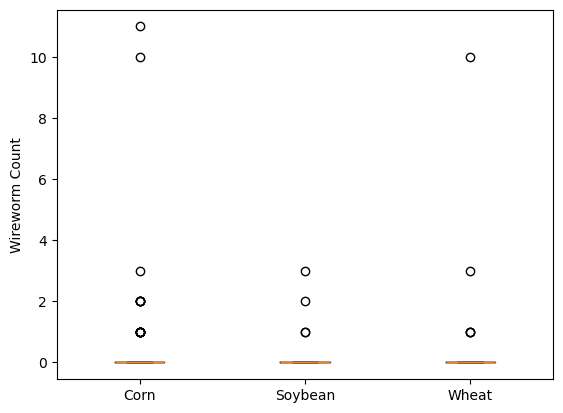

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.boxplot([wire_mesh_previous_crop.loc[wire_mesh_previous_crop["previous_crop"] == "Corn"]["number_wireworm"].dropna(),
    wire_mesh_previous_crop.loc[wire_mesh_previous_crop["previous_crop"] == "Soybean"]["number_wireworm"].dropna(),
    wire_mesh_previous_crop.loc[wire_mesh_previous_crop["previous_crop"] == "Wheat"]["number_wireworm"].dropna()])
ax.set_xticklabels(["Corn", "Soybean", "Wheat"]) 
ax.set_ylabel("Wireworm Count") 
plt.show()

In [ ]:
stats.kruskal(
    wire_mesh_previous_crop.loc[wire_mesh_previous_crop["previous_crop"] == "Corn"]["number_wireworm"].dropna(),
    wire_mesh_previous_crop.loc[wire_mesh_previous_crop["previous_crop"] == "Soybean"]["number_wireworm"].dropna(),
    wire_mesh_previous_crop.loc[wire_mesh_previous_crop["previous_crop"] == "Wheat"]["number_wireworm"].dropna(),
)

KruskalResult(statistic=5.3546926376378945, pvalue=0.06874534053153775)

In [ ]:
res = tukey_hsd(
    wire_mesh_previous_crop.loc[wire_mesh_previous_crop["previous_crop"] == "Corn"][
        "number_wireworm"
    ].dropna(),
    wire_mesh_previous_crop.loc[wire_mesh_previous_crop["previous_crop"] == "Soybean"][
        "number_wireworm"
    ].dropna(),
    wire_mesh_previous_crop.loc[wire_mesh_previous_crop["previous_crop"] == "Wheat"][
        "number_wireworm"
    ].dropna(),
)

print(res)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.021     0.995    -0.553     0.511
 (0 - 2)     -0.557     0.097    -1.190     0.076
 (1 - 0)      0.021     0.995    -0.511     0.553
 (1 - 2)     -0.536     0.241    -1.319     0.246
 (2 - 0)      0.557     0.097    -0.076     1.190
 (2 - 1)      0.536     0.241    -0.246     1.319



Group 0 = Corn  
Group 1 = Soybean  
Group 2 = Wheat  

0-2: Corn and Wheat
1-2: Soybean and Wheat

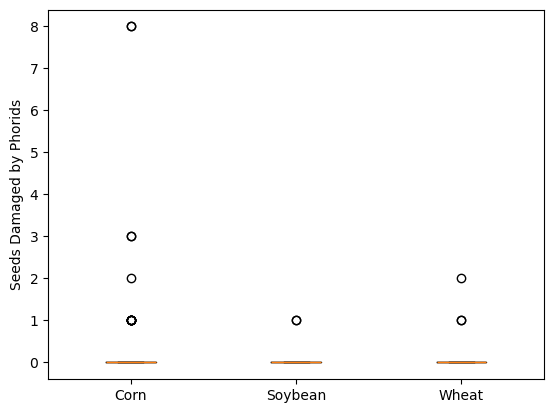

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.boxplot([wire_mesh_previous_crop.loc[wire_mesh_previous_crop["previous_crop"] == "Corn"]["phorid_seeds"].dropna(),
    wire_mesh_previous_crop.loc[wire_mesh_previous_crop["previous_crop"] == "Soybean"]["phorid_seeds"].dropna(),
    wire_mesh_previous_crop.loc[wire_mesh_previous_crop["previous_crop"] == "Wheat"]["phorid_seeds"].dropna()])
ax.set_xticklabels(["Corn", "Soybean", "Wheat"]) 
ax.set_ylabel("Seeds Damaged by Phorids") 
plt.show()

In [ ]:
stats.kruskal(
    wire_mesh_previous_crop.loc[wire_mesh_previous_crop["previous_crop"] == "Corn"]["phorid_seeds"].dropna(),
    wire_mesh_previous_crop.loc[wire_mesh_previous_crop["previous_crop"] == "Soybean"]["phorid_seeds"].dropna(),
    wire_mesh_previous_crop.loc[wire_mesh_previous_crop["previous_crop"] == "Wheat"]["phorid_seeds"].dropna(),
)

KruskalResult(statistic=2.016919252508742, pvalue=0.36478044524779035)

In [ ]:
stats.kruskal(
    wire_mesh_previous_crop.loc[wire_mesh_previous_crop["previous_crop"] == "Corn"]["total_phorid_maggots"].dropna(),
    wire_mesh_previous_crop.loc[wire_mesh_previous_crop["previous_crop"] == "Soybean"]["total_phorid_maggots"].dropna(),
    wire_mesh_previous_crop.loc[wire_mesh_previous_crop["previous_crop"] == "Wheat"]["total_phorid_maggots"].dropna(),
)

KruskalResult(statistic=1.1257206489005462, pvalue=0.5695775550318936)

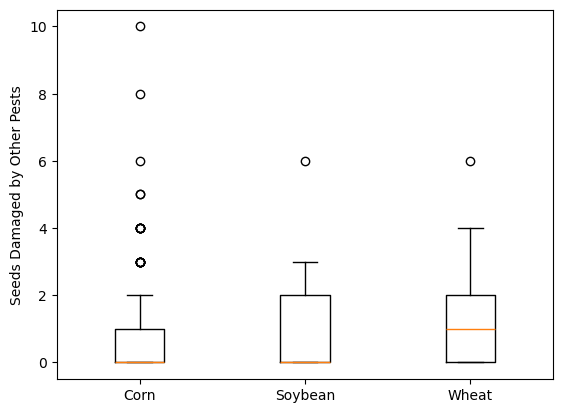

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.boxplot([wire_mesh_previous_crop.loc[wire_mesh_previous_crop["previous_crop"] == "Corn"]["other_seeds"].dropna(),
    wire_mesh_previous_crop.loc[wire_mesh_previous_crop["previous_crop"] == "Soybean"]["other_seeds"].dropna(),
    wire_mesh_previous_crop.loc[wire_mesh_previous_crop["previous_crop"] == "Wheat"]["other_seeds"].dropna()])
ax.set_xticklabels(["Corn", "Soybean", "Wheat"]) 
ax.set_ylabel("Seeds Damaged by Other Pests") 
plt.show()

In [ ]:
stats.kruskal(
    wire_mesh_previous_crop.loc[wire_mesh_previous_crop["previous_crop"] == "Corn"]["other_seeds"].dropna(),
    wire_mesh_previous_crop.loc[wire_mesh_previous_crop["previous_crop"] == "Soybean"]["other_seeds"].dropna(),
    wire_mesh_previous_crop.loc[wire_mesh_previous_crop["previous_crop"] == "Wheat"]["other_seeds"].dropna(),
)

KruskalResult(statistic=3.2953061073877277, pvalue=0.19250116877893175)

In [ ]:
res = tukey_hsd(
    wire_mesh_previous_crop.loc[wire_mesh_previous_crop["previous_crop"] == "Corn"][
        "other_seeds"
    ].dropna(),
    wire_mesh_previous_crop.loc[wire_mesh_previous_crop["previous_crop"] == "Soybean"][
        "other_seeds"
    ].dropna(),
    wire_mesh_previous_crop.loc[wire_mesh_previous_crop["previous_crop"] == "Wheat"][
        "other_seeds"
    ].dropna(),
)

print(res)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -0.154     0.842    -0.805     0.496
 (0 - 2)     -0.489     0.298    -1.263     0.285
 (1 - 0)      0.154     0.842    -0.496     0.805
 (1 - 2)     -0.335     0.688    -1.292     0.622
 (2 - 0)      0.489     0.298    -0.285     1.263
 (2 - 1)      0.335     0.688    -0.622     1.292



In [ ]:
wire_mesh_intake

,container_number,container_type,project,record_id,collection_date,notes
1525,3003,deli cup,R,DIP_CUR,4/18/23,NaN
1526,3004,deli cup,R,DIP_CUR,4/18/23,NaN
1527,3015,sushi container,R,DIP_CUR,4/18/23,NaN
1528,3016,sushi container,R,DIP_CUR,4/18/23,NaN
1529,3229,sushi container,R,DIP_CUR,5/2/23,NaN
...,...,...,...,...,...,...
2106,3670,deli cup,R,ZUE_REE,5/9/23,NaN
2107,4279,sushi container,R,ZUE_REE,5/23/23,NaN
2108,4280,sushi container,R,ZUE_REE,5/23/23,NaN
2109,4281,deli cup,R,ZUE_REE,5/25/23,NaN


In [ ]:
wire_mesh_intake['collection_date'] = pd.to_datetime(
    wire_mesh_intake["collection_date"], format="%m/%d/%y"
)

In [ ]:
card_id = scm_counts.merge(wire_mesh_intake, left_on=['site', 'collection_date'], right_on=['record_id', 'collection_date'], how='left')['card_id']
card_id = card_id.astype(int).drop_duplicates()

len(card_id)
card_id
#card_id.to_csv('Data/sticky_card_wire_mesh_overlapping.csv')

0       2001
1       2002
2       2003
3       2004
4       2005
        ... 
3174    7402
3175    7403
3176    7404
3177    7405
3178    7406
Name: card_id, Length: 2406, dtype: int64

In [31]:
scm_counts['total_m'] = scm_counts['n_scm_i_m'] + scm_counts['n_scm_o_m']
scm_counts['total_f'] = scm_counts['n_scm_i_f'] + scm_counts['n_scm_o_f']
scm_counts['total_scm'] = scm_counts['n_scm_i_m'] + scm_counts['n_scm_o_m'] + scm_counts['n_scm_i_f'] + scm_counts['n_scm_o_f']

In [ ]:
scm_counts

,card_id,data_collector,site,collection_date,n_scm_i_m,n_scm_i_f,n_scm_o_m,n_scm_o_f,n_d_florilega_i,n_d_florilega_o,initials,notes,week,total_m,total_f,total_scm
0,2001,Anna DiPaola,DIP_CUR,2023-03-13,0.0,0.0,0.0,0.0,0.0,0.0,YVH,NaN,11,0.0,0.0,0.0
1,2002,Anna DiPaola,DIP_CUR,2023-03-13,0.0,0.0,0.0,0.0,0.0,0.0,YVH,NaN,11,0.0,0.0,0.0
2,2003,Anna DiPaola,POV_DUN,2023-03-13,0.0,0.0,0.0,0.0,0.0,0.0,YVH,NaN,11,0.0,0.0,0.0
3,2004,Anna DiPaola,POV_DUN,2023-03-13,0.0,0.0,0.0,0.0,0.0,0.0,YVH,NaN,11,0.0,0.0,0.0
4,2005,Anna DiPaola,DIP_FLE,2023-03-13,0.0,0.0,0.0,0.0,0.0,0.0,YVH,NaN,11,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2401,7402,Alexa Stratton,DIP_CUR,2024-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01,NaN,NaN,NaN
2402,7403,Alexa Stratton,DIP_CUR,2023-01-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,03,NaN,NaN,NaN
2403,7404,Alexa Stratton,DIP_CUR,2023-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,04,NaN,NaN,NaN
2404,7405,Kitty O'Neil,ONE_STA_1,2023-06-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24,NaN,NaN,NaN


In [ ]:
wire_mesh

,id,container_number,project,seed_type,number_seeds,scm_seeds,other_seeds,total_scm_maggots,total_scm_pupae,number_wireworm,phorid_seeds,total_phorid_maggots,total_phorid_pupae,notes,container_type,collection_date,record_id
2,3,3011,R,Bean,8.0,1.0,2.0,1.0,2,0.0,1.0,2.0,3.0,NaN,deli cup,2023-04-17,GAB_ALL
8,9,3068,R,Bean,8.0,0.0,0.0,0.0,5,1.0,2.0,7.0,9.0,NaN,deli cup,2023-04-18,SMI_JOH_2
14,15,3010,R,Bean,10.0,0.0,1.0,0.0,0,0.0,0.0,0.0,19.0,NaN,deli cup,2023-04-17,GAB_STE
20,21,3003,R,Bean,5.0,0.0,1.0,0.0,17,0.0,0.0,0.0,0.0,NaN,deli cup,2023-04-18,DIP_CUR
29,30,3042,R,Bean,10.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,NaN,deli cup,2023-04-17,SMI_MCC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824,5085,5100,R,Corn,10.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,NaN,deli cup,2023-06-09,MIL_MCC
827,5097,5114,R,Corn,10.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,NaN,deli cup,2023-06-12,SMI_KEL
830,5103,5116,R,Corn,10.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,NaN,deli cup,2023-06-13,SMI_JOH_2
833,5184,5033,R,Corn,10.0,0.0,3.0,0.0,0,0.0,0.0,0.0,1.0,NaN,deli cup,2023-06-06,DIP_FLE


In [33]:
adult_and_risk = scm_counts.merge(wire_mesh, left_on=['collection_date', 'site'], right_on=['collection_date', 'record_id'], how='left')
adult_and_risk

,card_id,data_collector,site,collection_date,n_scm_i_m,n_scm_i_f,n_scm_o_m,n_scm_o_f,n_d_florilega_i,n_d_florilega_o,...,other_seeds,total_scm_maggots,total_scm_pupae,number_wireworm,phorid_seeds,total_phorid_maggots,total_phorid_pupae,notes_y,container_type,record_id
0,2001,Anna DiPaola,DIP_CUR,2023-03-13,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2002,Anna DiPaola,DIP_CUR,2023-03-13,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2003,Anna DiPaola,POV_DUN,2023-03-13,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2004,Anna DiPaola,POV_DUN,2023-03-13,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2005,Anna DiPaola,DIP_FLE,2023-03-13,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2650,7402,Alexa Stratton,DIP_CUR,2024-01-10,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2651,7403,Alexa Stratton,DIP_CUR,2023-01-16,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2652,7404,Alexa Stratton,DIP_CUR,2023-01-23,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2653,7405,Kitty O'Neil,ONE_STA_1,2023-06-12,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
adult_and_risk.drop_duplicates('card_id')

,card_id,data_collector,site,collection_date,n_scm_i_m,n_scm_i_f,n_scm_o_m,n_scm_o_f,n_d_florilega_i,n_d_florilega_o,...,other_seeds,total_scm_maggots,total_scm_pupae,number_wireworm,phorid_seeds,total_phorid_maggots,total_phorid_pupae,notes_y,container_type,record_id
0,2001,Anna DiPaola,DIP_CUR,2023-03-13,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2002,Anna DiPaola,DIP_CUR,2023-03-13,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2003,Anna DiPaola,POV_DUN,2023-03-13,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2004,Anna DiPaola,POV_DUN,2023-03-13,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2005,Anna DiPaola,DIP_FLE,2023-03-13,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2650,7402,Alexa Stratton,DIP_CUR,2024-01-10,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2651,7403,Alexa Stratton,DIP_CUR,2023-01-16,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2652,7404,Alexa Stratton,DIP_CUR,2023-01-23,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2653,7405,Kitty O'Neil,ONE_STA_1,2023-06-12,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
adult_and_risk.columns

Index(['card_id', 'data_collector', 'site', 'collection_date', 'n_scm_i_m',
       'n_scm_i_f', 'n_scm_o_m', 'n_scm_o_f', 'n_d_florilega_i',
       'n_d_florilega_o', 'initials', 'notes_x', 'week', 'total_m', 'total_f',
       'total_scm', 'id', 'container_number', 'project', 'seed_type',
       'number_seeds', 'scm_seeds', 'other_seeds', 'total_scm_maggots',
       'total_scm_pupae', 'number_wireworm', 'phorid_seeds',
       'total_phorid_maggots', 'total_phorid_pupae', 'notes_y',
       'container_type', 'record_id'],
      dtype='object')

In [36]:
adult_and_risk = adult_and_risk.drop(['data_collector', 'site', 'n_scm_i_m', 'n_scm_i_f', 'n_scm_o_m', 'n_scm_o_f', 'project', 'container_type'], axis=1)
adult_and_risk

,card_id,collection_date,n_d_florilega_i,n_d_florilega_o,initials,notes_x,week,total_m,total_f,total_scm,...,scm_seeds,other_seeds,total_scm_maggots,total_scm_pupae,number_wireworm,phorid_seeds,total_phorid_maggots,total_phorid_pupae,notes_y,record_id
0,2001,2023-03-13,0.0,0.0,YVH,NaN,11,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2002,2023-03-13,0.0,0.0,YVH,NaN,11,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2003,2023-03-13,0.0,0.0,YVH,NaN,11,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2004,2023-03-13,0.0,0.0,YVH,NaN,11,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2005,2023-03-13,0.0,0.0,YVH,NaN,11,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2650,7402,2024-01-10,NaN,NaN,NaN,NaN,01,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2651,7403,2023-01-16,NaN,NaN,NaN,NaN,03,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2652,7404,2023-01-23,NaN,NaN,NaN,NaN,04,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2653,7405,2023-06-12,NaN,NaN,NaN,NaN,24,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
adult_and_risk_drop_na = adult_and_risk.dropna(subset=['total_scm', 'total_scm_maggots'])
d = np.polyfit(adult_and_risk_drop_na['total_scm'],adult_and_risk_drop_na['total_scm_maggots'],1)
f = np.poly1d(d)

adult_and_risk_drop_na.insert(0, 'regression',f(adult_and_risk_drop_na['total_scm_maggots']))


In [38]:
sum(adult_and_risk_drop_na.loc[adult_and_risk_drop_na['seed_type'] == 'Corn']['total_scm_maggots'])

2.0

In [44]:
adult_and_risk_drop_na.columns

Index(['regression', 'card_id', 'collection_date', 'n_d_florilega_i',
       'n_d_florilega_o', 'initials', 'notes_x', 'week', 'total_m', 'total_f',
       'total_scm', 'id', 'container_number', 'seed_type', 'number_seeds',
       'scm_seeds', 'other_seeds', 'total_scm_maggots', 'total_scm_pupae',
       'number_wireworm', 'phorid_seeds', 'total_phorid_maggots',
       'total_phorid_pupae', 'notes_y', 'record_id'],
      dtype='object')

In [53]:
adult_and_risk_drop_na.to_csv('Data/for_hayley.csv')

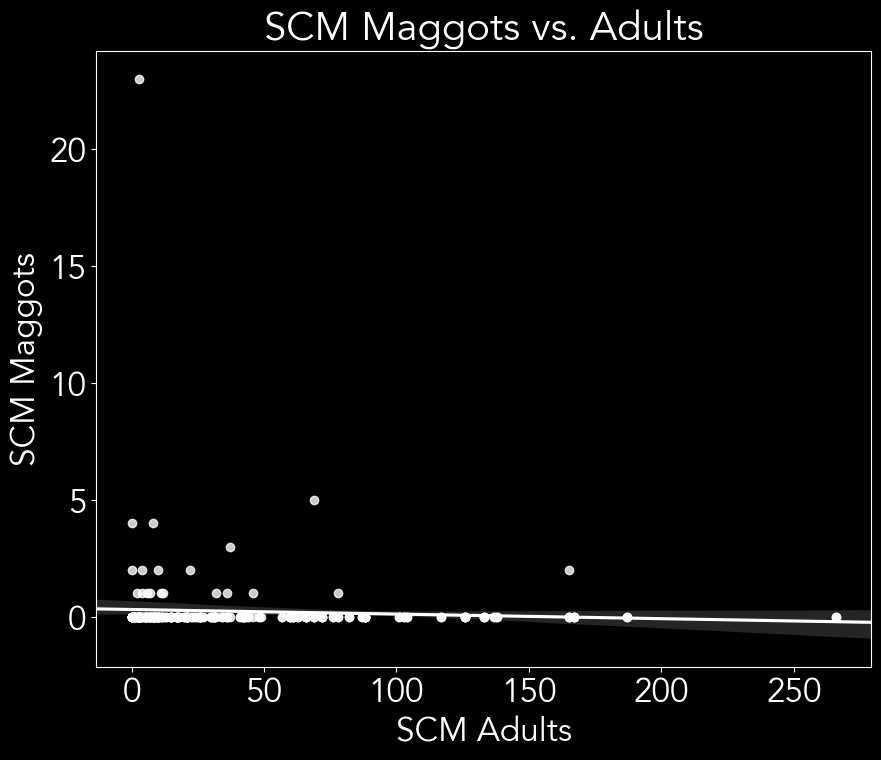

In [51]:
plt.rcParams['font.sans-serif'] = ['Avenir']
plt.style.use('dark_background')
plt.figure(figsize=(10,8))

plt.rcParams.update({'font.size': 24})

#ax = adult_and_risk_drop_na.drop_duplicates('card_id').plot.scatter(x = 'total_scm', y = 'total_scm_maggots')

sns.regplot(
    data=adult_and_risk_drop_na, x="total_scm", y="total_scm_maggots",
    scatter=True, truncate=False, order=1, color="white",
)

plt.xlabel('SCM Adults')
plt.ylabel('SCM Maggots')
plt.title('SCM Maggots vs. Adults')
plt.show()

In [40]:
plt.rcParams['font.sans-serif'] = ['Avenir']
plt.rcParams.update({'font.size': 16})

adult_and_risk_drop_na_bean = adult_and_risk_drop_na.loc[adult_and_risk_drop_na['seed_type'] == 'Bean']

#ax = adult_and_risk_drop_na_bean.drop_duplicates('card_id').plot.scatter(x = 'total_scm', y = 'total_scm_maggots')

sns.regplot(
    data=adult_and_risk_drop_na_bean, x="total_scm_x", y="total_scm_maggots",
    scatter=True, truncate=False, order=1, color=".2",
)

plt.xlabel('SCM Adults')
plt.ylabel('SCM Maggots')
plt.title('SCM Maggots vs. Adults - Lima Beans')

plt.title('SCM Maggots vs. Adults - Lima Beans', y=1.03)

plt.show()

KeyError: 'total_scm_x'

In [29]:
slope, intercept, r_value, p_value, std_err = stats.linregress(adult_and_risk_drop_na['total_scm'],adult_and_risk_drop_na['total_scm_maggots'])
slope, intercept, r_value, p_value, std_err

NameError: name 'adult_and_risk_drop_na' is not defined

In [96]:
slope, intercept, r_value, p_value, std_err = stats.linregress(adult_and_risk_drop_na_bean['total_scm'],adult_and_risk_drop_na_bean['total_scm_maggots'])
slope, intercept, r_value, p_value, std_err

NameError: name 'adult_and_risk_drop_na_bean' is not defined

In [97]:
wire_mesh_intake

,container_number,container_type,project,record_id,collection_date,notes
1525,3003,deli cup,R,DIP_CUR,2023-04-18,NaN
1526,3004,deli cup,R,DIP_CUR,2023-04-18,NaN
1527,3015,sushi container,R,DIP_CUR,2023-04-18,NaN
1528,3016,sushi container,R,DIP_CUR,2023-04-18,NaN
1529,3229,sushi container,R,DIP_CUR,2023-05-02,NaN
...,...,...,...,...,...,...
2106,3670,deli cup,R,ZUE_REE,2023-05-09,NaN
2107,4279,sushi container,R,ZUE_REE,2023-05-23,NaN
2108,4280,sushi container,R,ZUE_REE,2023-05-23,NaN
2109,4281,deli cup,R,ZUE_REE,2023-05-25,NaN


In [98]:
germination

,container_nr,date_collected,seed_type,date_1st_measure,nr_seeds_germinated_1st_measure,date_2nd_measure,nr_seeds_germinated_2nd_measure,nr_seeds_with_root_only,nr_seeds_with_shoot_only,nr_seeds_with_both_root_and_shoot,nr_seeds_not_germinated,dry_aboveground_biomass_of_seedlings,dry_belowground_biomass_of_seedlings
0,3013,4/18/23,corn,4/19/23,5,4/27/23,7.0,0.0,0.0,7.0,3.0,NaN,NaN
1,3014,4/18/23,lima,4/19/23,0,4/27/23,0.0,0.0,0.0,0.0,10.0,NaN,NaN
2,3015,4/18/23,lima,4/19/23,0,4/27/23,0.0,0.0,0.0,0.0,10.0,NaN,NaN
3,3016,4/18/23,corn,4/19/23,8,4/27/23,10.0,0.0,0.0,10.0,0.0,NaN,NaN
4,3017,4/18/23,corn,4/19/23,6,4/27/23,6.0,0.0,1.0,5.0,4.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,5138,6/27/23,corn,7/3/23,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
297,4783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.51086,0.74461
298,5014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.53330,0.07336
299,4043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.54062,0.35735


In [99]:
germination = germination.merge(wire_mesh_intake, right_on=['container_number'], left_on=['container_nr'], how='left')
germination

,container_nr,date_collected,seed_type,date_1st_measure,nr_seeds_germinated_1st_measure,date_2nd_measure,nr_seeds_germinated_2nd_measure,nr_seeds_with_root_only,nr_seeds_with_shoot_only,nr_seeds_with_both_root_and_shoot,nr_seeds_not_germinated,dry_aboveground_biomass_of_seedlings,dry_belowground_biomass_of_seedlings,container_number,container_type,project,record_id,collection_date,notes
0,3013,4/18/23,corn,4/19/23,5,4/27/23,7.0,0.0,0.0,7.0,3.0,NaN,NaN,3013.0,sushi container,R,DIP_FLE,2023-04-18,NaN
1,3014,4/18/23,lima,4/19/23,0,4/27/23,0.0,0.0,0.0,0.0,10.0,NaN,NaN,3014.0,sushi container,R,DIP_FLE,2023-04-18,NaN
2,3015,4/18/23,lima,4/19/23,0,4/27/23,0.0,0.0,0.0,0.0,10.0,NaN,NaN,3015.0,sushi container,R,DIP_CUR,2023-04-18,NaN
3,3016,4/18/23,corn,4/19/23,8,4/27/23,10.0,0.0,0.0,10.0,0.0,NaN,NaN,3016.0,sushi container,R,DIP_CUR,2023-04-18,NaN
4,3017,4/18/23,corn,4/19/23,6,4/27/23,6.0,0.0,1.0,5.0,4.0,NaN,NaN,3017.0,sushi container,R,DIP_PAT,2023-04-18,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,5138,6/27/23,corn,7/3/23,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5138.0,sushi container,R,SMI_KEL,2023-06-27,NaN
297,4783,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.51086,0.74461,4783.0,deli cup,R,DIP_CUR,2023-06-02,NaN
298,5014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.53330,0.07336,5014.0,deli cup,R,LABWIS1,2023-06-05,NaN
299,4043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.54062,0.35735,4043.0,sushi container,R,SMI_MCC,2023-05-15,NaN


In [100]:
germination["date_collected"] = pd.to_datetime(germination["date_collected"], format="%m/%d/%y")
germination

,container_nr,date_collected,seed_type,date_1st_measure,nr_seeds_germinated_1st_measure,date_2nd_measure,nr_seeds_germinated_2nd_measure,nr_seeds_with_root_only,nr_seeds_with_shoot_only,nr_seeds_with_both_root_and_shoot,nr_seeds_not_germinated,dry_aboveground_biomass_of_seedlings,dry_belowground_biomass_of_seedlings,container_number,container_type,project,record_id,collection_date,notes
0,3013,2023-04-18,corn,4/19/23,5,4/27/23,7.0,0.0,0.0,7.0,3.0,NaN,NaN,3013.0,sushi container,R,DIP_FLE,2023-04-18,NaN
1,3014,2023-04-18,lima,4/19/23,0,4/27/23,0.0,0.0,0.0,0.0,10.0,NaN,NaN,3014.0,sushi container,R,DIP_FLE,2023-04-18,NaN
2,3015,2023-04-18,lima,4/19/23,0,4/27/23,0.0,0.0,0.0,0.0,10.0,NaN,NaN,3015.0,sushi container,R,DIP_CUR,2023-04-18,NaN
3,3016,2023-04-18,corn,4/19/23,8,4/27/23,10.0,0.0,0.0,10.0,0.0,NaN,NaN,3016.0,sushi container,R,DIP_CUR,2023-04-18,NaN
4,3017,2023-04-18,corn,4/19/23,6,4/27/23,6.0,0.0,1.0,5.0,4.0,NaN,NaN,3017.0,sushi container,R,DIP_PAT,2023-04-18,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,5138,2023-06-27,corn,7/3/23,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5138.0,sushi container,R,SMI_KEL,2023-06-27,NaN
297,4783,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.51086,0.74461,4783.0,deli cup,R,DIP_CUR,2023-06-02,NaN
298,5014,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.53330,0.07336,5014.0,deli cup,R,LABWIS1,2023-06-05,NaN
299,4043,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.54062,0.35735,4043.0,sushi container,R,SMI_MCC,2023-05-15,NaN


In [101]:
germination['seed_type'] = germination['seed_type'].replace({'corn':'Corn', 'lima':'Bean'})
germination

,container_nr,date_collected,seed_type,date_1st_measure,nr_seeds_germinated_1st_measure,date_2nd_measure,nr_seeds_germinated_2nd_measure,nr_seeds_with_root_only,nr_seeds_with_shoot_only,nr_seeds_with_both_root_and_shoot,nr_seeds_not_germinated,dry_aboveground_biomass_of_seedlings,dry_belowground_biomass_of_seedlings,container_number,container_type,project,record_id,collection_date,notes
0,3013,2023-04-18,Corn,4/19/23,5,4/27/23,7.0,0.0,0.0,7.0,3.0,NaN,NaN,3013.0,sushi container,R,DIP_FLE,2023-04-18,NaN
1,3014,2023-04-18,Bean,4/19/23,0,4/27/23,0.0,0.0,0.0,0.0,10.0,NaN,NaN,3014.0,sushi container,R,DIP_FLE,2023-04-18,NaN
2,3015,2023-04-18,Bean,4/19/23,0,4/27/23,0.0,0.0,0.0,0.0,10.0,NaN,NaN,3015.0,sushi container,R,DIP_CUR,2023-04-18,NaN
3,3016,2023-04-18,Corn,4/19/23,8,4/27/23,10.0,0.0,0.0,10.0,0.0,NaN,NaN,3016.0,sushi container,R,DIP_CUR,2023-04-18,NaN
4,3017,2023-04-18,Corn,4/19/23,6,4/27/23,6.0,0.0,1.0,5.0,4.0,NaN,NaN,3017.0,sushi container,R,DIP_PAT,2023-04-18,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,5138,2023-06-27,Corn,7/3/23,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5138.0,sushi container,R,SMI_KEL,2023-06-27,NaN
297,4783,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.51086,0.74461,4783.0,deli cup,R,DIP_CUR,2023-06-02,NaN
298,5014,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.53330,0.07336,5014.0,deli cup,R,LABWIS1,2023-06-05,NaN
299,4043,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.54062,0.35735,4043.0,sushi container,R,SMI_MCC,2023-05-15,NaN


In [102]:
wire_mesh

,id,container_number,project,seed_type,number_seeds,scm_seeds,other_seeds,total_scm_maggots,total_scm_pupae,number_wireworm,...,max_temp_f_one_week,rain_inches_two_weeks,min_temp_f_two_weeks,ave_temp_f_two_weeks,max_temp_f_two_weeks,week,last_week,field_id_y,planting_date,start_week
0,3,3011,R,Bean,8.0,1.0,2.0,1.0,2,0.0,...,76.9000,0.036000,42.300000,54.346667,66.400000,16,15,GAB_ALL,2023-05-09,2023-05-02
1,9,3068,R,Bean,8.0,0.0,0.0,0.0,5,1.0,...,75.3875,0.118000,40.886667,53.466667,66.046667,16,15,NaN,NaT,NaT
2,15,3010,R,Bean,10.0,0.0,1.0,0.0,0,0.0,...,76.2875,0.039333,40.573333,53.080000,65.600000,16,15,GAB_STE,2023-05-23,2023-05-16
3,21,3003,R,Bean,5.0,0.0,1.0,0.0,17,0.0,...,70.7500,0.120000,38.533333,50.920000,63.313333,16,15,DIP_CUR,2023-05-19,2023-05-12
4,30,3042,R,Bean,10.0,0.0,0.0,0.0,1,0.0,...,70.7125,0.140000,35.206667,47.866667,60.546667,16,15,SMI_MCC,2023-05-15,2023-05-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,5085,5100,R,Corn,10.0,0.0,0.0,0.0,0,0.0,...,72.1000,0.041333,45.140000,59.613333,74.113333,23,22,NaN,NaT,NaT
284,5097,5114,R,Corn,10.0,0.0,0.0,0.0,0,0.0,...,69.0875,0.068000,49.493333,62.820000,76.166667,24,23,NaN,NaT,NaT
285,5103,5116,R,Corn,10.0,0.0,0.0,0.0,0,0.0,...,70.5750,0.100667,52.373333,64.440000,76.480000,24,23,NaN,NaT,NaT
286,5184,5033,R,Corn,10.0,0.0,3.0,0.0,0,0.0,...,79.6875,0.003333,47.646667,61.553333,75.466667,23,22,DIP_FLE,2023-05-23,2023-05-16


In [103]:
germination_wire_mesh = germination.merge(wire_mesh[['record_id','seed_type', 'number_seeds',
       'scm_seeds', 'other_seeds', 'total_scm_maggots', 'total_scm_pupae',
       'number_wireworm', 'phorid_seeds', 'total_phorid_maggots',
       'total_phorid_pupae', 'collection_date']], left_on=['record_id', 'date_collected', 'seed_type'], right_on=['record_id', 'collection_date', 'seed_type'], how='left')
germination_wire_mesh

,container_nr,date_collected,seed_type,date_1st_measure,nr_seeds_germinated_1st_measure,date_2nd_measure,nr_seeds_germinated_2nd_measure,nr_seeds_with_root_only,nr_seeds_with_shoot_only,nr_seeds_with_both_root_and_shoot,...,number_seeds,scm_seeds,other_seeds,total_scm_maggots,total_scm_pupae,number_wireworm,phorid_seeds,total_phorid_maggots,total_phorid_pupae,collection_date_y
0,3013,2023-04-18,Corn,4/19/23,5,4/27/23,7.0,0.0,0.0,7.0,...,9.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2023-04-18
1,3014,2023-04-18,Bean,4/19/23,0,4/27/23,0.0,0.0,0.0,0.0,...,10.0,0.0,1.0,0.0,32.0,0.0,0.0,0.0,10.0,2023-04-18
2,3015,2023-04-18,Bean,4/19/23,0,4/27/23,0.0,0.0,0.0,0.0,...,5.0,0.0,1.0,0.0,17.0,0.0,0.0,0.0,0.0,2023-04-18
3,3016,2023-04-18,Corn,4/19/23,8,4/27/23,10.0,0.0,0.0,10.0,...,9.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,2023-04-18
4,3017,2023-04-18,Corn,4/19/23,6,4/27/23,6.0,0.0,1.0,5.0,...,10.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-04-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,5138,2023-06-27,Corn,7/3/23,10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
312,4783,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
313,5014,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
314,4043,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [104]:
germination_wire_mesh.columns

Index(['container_nr', 'date_collected', 'seed_type', 'date_1st_measure',
       'nr_seeds_germinated_1st_measure', 'date_2nd_measure',
       'nr_seeds_germinated_2nd_measure', 'nr_seeds_with_root_only',
       'nr_seeds_with_shoot_only', 'nr_seeds_with_both_root_and_shoot',
       'nr_seeds_not_germinated', 'dry_aboveground_biomass_of_seedlings',
       'dry_belowground_biomass_of_seedlings', 'container_number',
       'container_type', 'project', 'record_id', 'collection_date_x', 'notes',
       'number_seeds', 'scm_seeds', 'other_seeds', 'total_scm_maggots',
       'total_scm_pupae', 'number_wireworm', 'phorid_seeds',
       'total_phorid_maggots', 'total_phorid_pupae', 'collection_date_y'],
      dtype='object')

In [105]:
germination_wire_mesh = germination_wire_mesh[pd.to_numeric(germination_wire_mesh['nr_seeds_germinated_1st_measure'], errors='coerce').notnull()]
germination_wire_mesh['nr_seeds_germinated_1st_measure'] = germination_wire_mesh['nr_seeds_germinated_1st_measure'].astype('int')
germination_wire_mesh = germination_wire_mesh.dropna(subset = ['nr_seeds_germinated_1st_measure', 'total_scm_maggots'])
germination_wire_mesh

/var/folders/vt/gz9c8wh17772k93xq1vtnl0c0000gn/T/ipykernel_45936/2622140312.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  germination_wire_mesh['nr_seeds_germinated_1st_measure'] = germination_wire_mesh['nr_seeds_germinated_1st_measure'].astype('int')


,container_nr,date_collected,seed_type,date_1st_measure,nr_seeds_germinated_1st_measure,date_2nd_measure,nr_seeds_germinated_2nd_measure,nr_seeds_with_root_only,nr_seeds_with_shoot_only,nr_seeds_with_both_root_and_shoot,...,number_seeds,scm_seeds,other_seeds,total_scm_maggots,total_scm_pupae,number_wireworm,phorid_seeds,total_phorid_maggots,total_phorid_pupae,collection_date_y
0,3013,2023-04-18,Corn,4/19/23,5,4/27/23,7.0,0.0,0.0,7.0,...,9.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2023-04-18
1,3014,2023-04-18,Bean,4/19/23,0,4/27/23,0.0,0.0,0.0,0.0,...,10.0,0.0,1.0,0.0,32.0,0.0,0.0,0.0,10.0,2023-04-18
2,3015,2023-04-18,Bean,4/19/23,0,4/27/23,0.0,0.0,0.0,0.0,...,5.0,0.0,1.0,0.0,17.0,0.0,0.0,0.0,0.0,2023-04-18
3,3016,2023-04-18,Corn,4/19/23,8,4/27/23,10.0,0.0,0.0,10.0,...,9.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,2023-04-18
4,3017,2023-04-18,Corn,4/19/23,6,4/27/23,6.0,0.0,1.0,5.0,...,10.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-04-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,5130,2023-06-12,Corn,6/23/23,10,no second measure,NaN,NaN,NaN,10.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-06-12
304,5131,2023-06-12,Corn,6/23/23,9,no second measure,NaN,NaN,NaN,9.0,...,10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-06-12
305,5132,2023-06-13,Bean,6/23/23,6,no second measure,NaN,NaN,NaN,6.0,...,10.0,0.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,2023-06-13
306,5133,2023-06-12,Bean,6/23/23,0,no second measure,NaN,NaN,NaN,NaN,...,10.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-06-12


In [106]:
germination_wire_mesh_drop_na = germination_wire_mesh.dropna(subset=['total_scm_maggots', 'nr_seeds_germinated_1st_measure'])



In [107]:
slope, intercept, r_value, p_value, std_err = stats.linregress(germination_wire_mesh_drop_na['total_scm_maggots'],germination_wire_mesh_drop_na['nr_seeds_germinated_1st_measure'])
slope, intercept, r_value, p_value, std_err

(-0.3414740752882046,
 4.22542752554226,
 -0.12808974329791595,
 0.0375336599832816,
 0.16334297274766332)

(-0.5, 10.5)

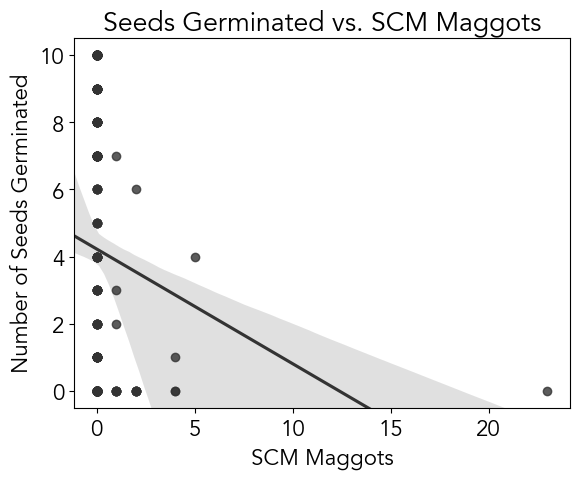

In [108]:
#ax = sns.stripplot(x = 'total_scm_maggots', y = 'nr_seeds_germinated_1st_measure', data=germination_wire_mesh_drop_na)

sns.regplot(
    data=germination_wire_mesh_drop_na, x="total_scm_maggots", y="nr_seeds_germinated_1st_measure",
    scatter=True, truncate=False, order=1, color=".2",
)

plt.xlabel('SCM Maggots')
plt.ylabel('Number of Seeds Germinated')
plt.title('Seeds Germinated vs. SCM Maggots')
plt.ylim(-0.5, 10.5)


In [109]:
germination_wire_mesh_drop_na = germination_wire_mesh_drop_na.rename({'seed_type':'Seed Type'}, axis=1)
germination_wire_mesh_drop_na

,container_nr,date_collected,Seed Type,date_1st_measure,nr_seeds_germinated_1st_measure,date_2nd_measure,nr_seeds_germinated_2nd_measure,nr_seeds_with_root_only,nr_seeds_with_shoot_only,nr_seeds_with_both_root_and_shoot,...,number_seeds,scm_seeds,other_seeds,total_scm_maggots,total_scm_pupae,number_wireworm,phorid_seeds,total_phorid_maggots,total_phorid_pupae,collection_date_y
0,3013,2023-04-18,Corn,4/19/23,5,4/27/23,7.0,0.0,0.0,7.0,...,9.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2023-04-18
1,3014,2023-04-18,Bean,4/19/23,0,4/27/23,0.0,0.0,0.0,0.0,...,10.0,0.0,1.0,0.0,32.0,0.0,0.0,0.0,10.0,2023-04-18
2,3015,2023-04-18,Bean,4/19/23,0,4/27/23,0.0,0.0,0.0,0.0,...,5.0,0.0,1.0,0.0,17.0,0.0,0.0,0.0,0.0,2023-04-18
3,3016,2023-04-18,Corn,4/19/23,8,4/27/23,10.0,0.0,0.0,10.0,...,9.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,2023-04-18
4,3017,2023-04-18,Corn,4/19/23,6,4/27/23,6.0,0.0,1.0,5.0,...,10.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-04-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,5130,2023-06-12,Corn,6/23/23,10,no second measure,NaN,NaN,NaN,10.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-06-12
304,5131,2023-06-12,Corn,6/23/23,9,no second measure,NaN,NaN,NaN,9.0,...,10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-06-12
305,5132,2023-06-13,Bean,6/23/23,6,no second measure,NaN,NaN,NaN,6.0,...,10.0,0.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,2023-06-13
306,5133,2023-06-12,Bean,6/23/23,0,no second measure,NaN,NaN,NaN,NaN,...,10.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-06-12


In [110]:
np.unique(germination_wire_mesh_drop_na['Seed Type'])

array(['Bean', 'Corn'], dtype=object)

/Users/chloecho/anaconda3/envs/cornell_dev/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chloecho/anaconda3/envs/cornell_dev/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


-0.12808974329791592

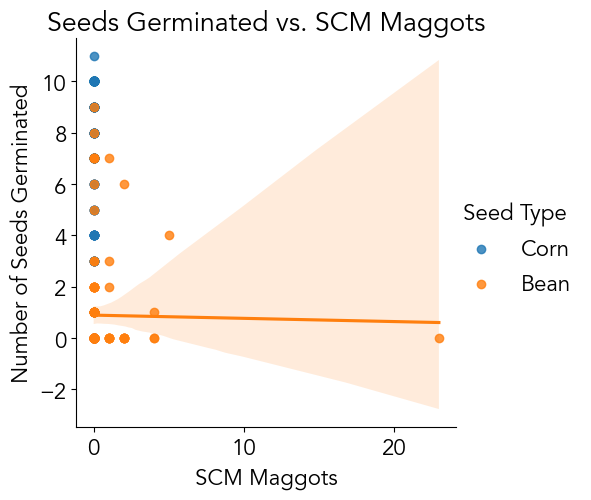

In [112]:
sns.lmplot(data=germination_wire_mesh_drop_na, x="total_scm_maggots", y="nr_seeds_germinated_1st_measure", hue="Seed Type")

plt.xlabel('SCM Maggots')
plt.ylabel('Number of Seeds Germinated')
plt.title('Seeds Germinated vs. SCM Maggots')


In [114]:
germination_wire_mesh_drop_na_bean = germination_wire_mesh_drop_na.loc[germination_wire_mesh_drop_na['Seed Type'] == 'Bean']
germination_wire_mesh_drop_na_bean

,container_nr,date_collected,Seed Type,date_1st_measure,nr_seeds_germinated_1st_measure,date_2nd_measure,nr_seeds_germinated_2nd_measure,nr_seeds_with_root_only,nr_seeds_with_shoot_only,nr_seeds_with_both_root_and_shoot,...,number_seeds,scm_seeds,other_seeds,total_scm_maggots,total_scm_pupae,number_wireworm,phorid_seeds,total_phorid_maggots,total_phorid_pupae,collection_date_y
1,3014,2023-04-18,Bean,4/19/23,0,4/27/23,0.0,0.0,0.0,0.0,...,10.0,0.0,1.0,0.0,32.0,0.0,0.0,0.0,10.0,2023-04-18
2,3015,2023-04-18,Bean,4/19/23,0,4/27/23,0.0,0.0,0.0,0.0,...,5.0,0.0,1.0,0.0,17.0,0.0,0.0,0.0,0.0,2023-04-18
5,3018,2023-04-18,Bean,4/19/23,1,4/27/23,NaN,NaN,NaN,NaN,...,10.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,8.0,2023-04-18
7,3020,2023-04-18,Bean,4/19/23,0,4/27/23,0.0,0.0,0.0,0.0,...,11.0,1.0,1.0,1.0,0.0,2.0,1.0,10.0,0.0,2023-04-18
9,3022,2023-04-17,Bean,4/19/23,0,4/27/23,NaN,NaN,NaN,NaN,...,8.0,1.0,2.0,1.0,2.0,0.0,1.0,2.0,3.0,2023-04-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,5125,2023-06-14,Bean,6/23/23,7,no second measure,NaN,NaN,NaN,7.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-06-14
299,5126,2023-06-12,Bean,6/23/23,0,no second measure,NaN,NaN,NaN,NaN,...,10.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-06-12
300,5127,2023-06-12,Bean,6/23/23,8,no second measure,NaN,NaN,NaN,8.0,...,10.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-06-12
305,5132,2023-06-13,Bean,6/23/23,6,no second measure,NaN,NaN,NaN,6.0,...,10.0,0.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,2023-06-13


PearsonRResult(statistic=-0.014111335770388065, pvalue=0.87438331347965)

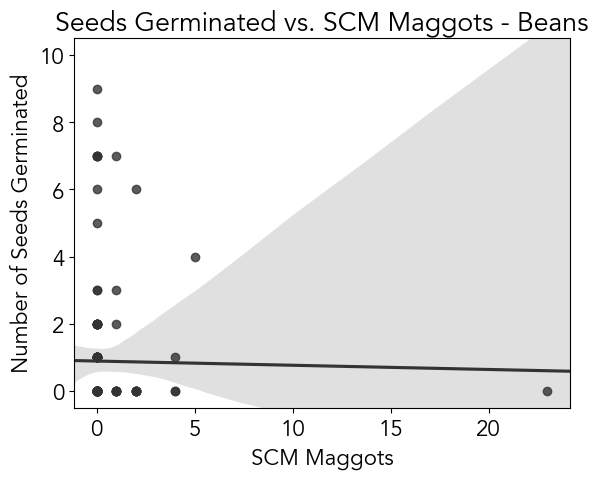

In [116]:
#ax = sns.stripplot(x = 'total_scm_maggots', y = 'nr_seeds_germinated_1st_measure', data=germination_wire_mesh_drop_na_bean)

sns.regplot(
    data=germination_wire_mesh_drop_na_bean, x="total_scm_maggots", y="nr_seeds_germinated_1st_measure",
    scatter=True, truncate=False, order=1, color=".2",
)

plt.xlabel('SCM Maggots')
plt.ylabel('Number of Seeds Germinated')
plt.title('Seeds Germinated vs. SCM Maggots - Beans')
plt.ylim(-0.5, 10.5)

pearsonr(germination_wire_mesh_drop_na_bean['total_scm_maggots'], germination_wire_mesh_drop_na_bean['nr_seeds_germinated_1st_measure'])

In [ ]:
germination_wire_mesh_drop_na_corn = germination_wire_mesh_drop_na.loc[germination_wire_mesh_drop_na['Seed Type'] == 'Corn']
germination_wire_mesh_drop_na_corn.drop_duplicates()

,container_nr,date_collected,Seed Type,date_1st_measure,nr_seeds_germinated_1st_measure,date_2nd_measure,nr_seeds_germinated_2nd_measure,nr_seeds_with_root_only,nr_seeds_with_shoot_only,nr_seeds_with_both_root_and_shoot,...,number_seeds,scm_seeds,other_seeds,total_scm_maggots,total_scm_pupae,number_wireworm,phorid_seeds,total_phorid_maggots,total_phorid_pupae,collection_date_y
0,3013,2023-04-18,Corn,4/19/23,5,4/27/23,7.0,0.0,0.0,7.0,...,9.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2023-04-18
3,3016,2023-04-18,Corn,4/19/23,8,4/27/23,10.0,0.0,0.0,10.0,...,9.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,2023-04-18
4,3017,2023-04-18,Corn,4/19/23,6,4/27/23,6.0,0.0,1.0,5.0,...,10.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-04-18
6,3019,2023-04-18,Corn,4/19/23,7,4/27/23,10.0,0.0,0.0,10.0,...,10.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,2023-04-18
8,3021,2023-04-17,Corn,4/19/23,7,4/27/23,9.0,0.0,0.0,9.0,...,10.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,2023-04-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
301,5128,2023-06-14,Corn,6/23/23,9,no second measure,NaN,NaN,NaN,9.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-06-14
302,5129,2023-06-13,Corn,6/23/23,6,no second measure,NaN,NaN,NaN,6.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-06-13
303,5130,2023-06-12,Corn,6/23/23,10,no second measure,NaN,NaN,NaN,10.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-06-12
304,5131,2023-06-12,Corn,6/23/23,9,no second measure,NaN,NaN,NaN,9.0,...,10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2023-06-12


/Users/chloecho/anaconda3/envs/cornell_dev/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chloecho/anaconda3/envs/cornell_dev/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chloecho/anaconda3/envs/cornell_dev/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chloecho/anaconda3/envs/cornell_dev/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecat

(-0.5, 10.5)

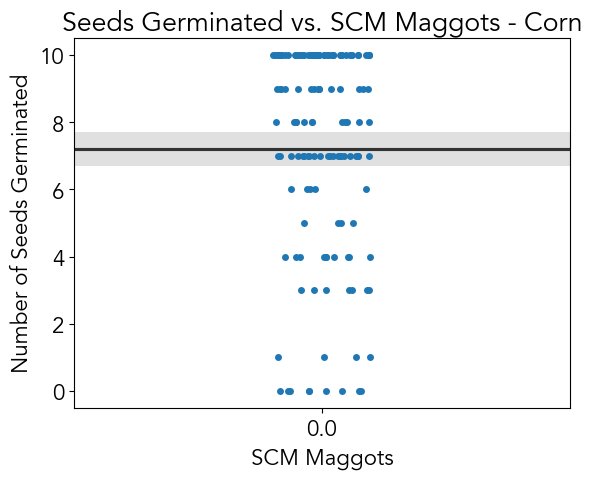

In [ ]:
ax = sns.stripplot(x = 'total_scm_maggots', y = 'nr_seeds_germinated_1st_measure', data=germination_wire_mesh_drop_na_corn)

sns.regplot(
    data=germination_wire_mesh_drop_na_corn, x="total_scm_maggots", y="nr_seeds_germinated_1st_measure",
    scatter=False, truncate=False, order=1, color=".2",
)

plt.xlabel('SCM Maggots')
plt.ylabel('Number of Seeds Germinated')
plt.title('Seeds Germinated vs. SCM Maggots - Corn')
plt.ylim(-0.5, 10.5)


In [ ]:
slope, intercept, r_value, p_value, std_err = stats.linregress(germination_wire_mesh_drop_na_corn['total_scm_maggots'],germination_wire_mesh_drop_na_corn['nr_seeds_germinated_1st_measure'])
slope, intercept, r_value, p_value, std_err

ValueError: Cannot calculate a linear regression if all x values are identical

In [ ]:
slope, intercept, r_value, p_value, std_err = stats.linregress(germination_wire_mesh_drop_na_bean['total_scm_maggots'],germination_wire_mesh_drop_na_bean['nr_seeds_germinated_1st_measure'])
slope, intercept, r_value, p_value, std_err

(-0.01252842989861609,
 0.8889788365907251,
 -0.014111335770388055,
 0.874383313479651,
 0.07908607170623724)

In [ ]:
merged_df = germination_wire_mesh_drop_na.merge(
    adult_and_risk_drop_na,
    left_on=[
        "record_id",
        "date_collected",
        "number_seeds",
        "scm_seeds",
        "other_seeds",
        "total_scm_maggots",
        "total_scm_pupae",
        "number_wireworm",
        "phorid_seeds",
        "total_phorid_maggots",
        "total_phorid_pupae",
    ],
    right_on=[
        "record_id",
        "collection_date",
        "number_seeds",
        "scm_seeds",
        "other_seeds",
        "total_scm_maggots",
        "total_scm_pupae",
        "number_wireworm",
        "phorid_seeds",
        "total_phorid_maggots",
        "total_phorid_pupae",
    ],
    how="left",
)

In [ ]:
merged_df = merged_df.dropna(subset=['total_scm', 'nr_seeds_germinated_1st_measure'])
merged_df

,container_nr,date_collected,Seed Type,date_1st_measure,nr_seeds_germinated_1st_measure,date_2nd_measure,nr_seeds_germinated_2nd_measure,nr_seeds_with_root_only,nr_seeds_with_shoot_only,nr_seeds_with_both_root_and_shoot,...,n_d_florilega_i,n_d_florilega_o,week,total_m,total_f,total_scm,id,container_number_y,seed_type,collection_date
0,3013,2023-04-18,Corn,4/19/23,5,4/27/23,7.0,0.0,0.0,7.0,...,0.0,0.0,16.0,64.0,24.0,88.0,60.0,3008.0,Corn,2023-04-18
1,3014,2023-04-18,Bean,4/19/23,0,4/27/23,0.0,0.0,0.0,0.0,...,0.0,0.0,16.0,64.0,24.0,88.0,63.0,3006.0,Bean,2023-04-18
2,3015,2023-04-18,Bean,4/19/23,0,4/27/23,0.0,0.0,0.0,0.0,...,0.0,0.0,16.0,25.0,35.0,60.0,21.0,3003.0,Bean,2023-04-18
3,3016,2023-04-18,Corn,4/19/23,8,4/27/23,10.0,0.0,0.0,10.0,...,0.0,0.0,16.0,25.0,35.0,60.0,27.0,3004.0,Corn,2023-04-18
4,3017,2023-04-18,Corn,4/19/23,6,4/27/23,6.0,0.0,1.0,5.0,...,0.0,0.0,16.0,44.0,28.0,72.0,24.0,3005.0,Corn,2023-04-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,4051,2023-05-15,Bean,5/19/23,0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,20.0,1.0,2.0,3.0,2436.0,5005.0,Bean,2023-05-15
184,4064,2023-05-15,Corn,5/19/23,6,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,20.0,8.0,2.0,10.0,3027.0,4082.0,Corn,2023-05-15
185,4065,2023-05-15,Bean,5/19/23,0,5/31/23,0.0,0.0,0.0,0.0,...,0.0,0.0,20.0,8.0,2.0,10.0,2415.0,4099.0,Bean,2023-05-15
188,4068,2023-05-15,Bean,5/19/23,0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,20.0,8.0,1.0,9.0,2709.0,4098.0,Bean,2023-05-15


Text(0.5, 1.0, 'Seeds Germinated vs. SCM Adults')

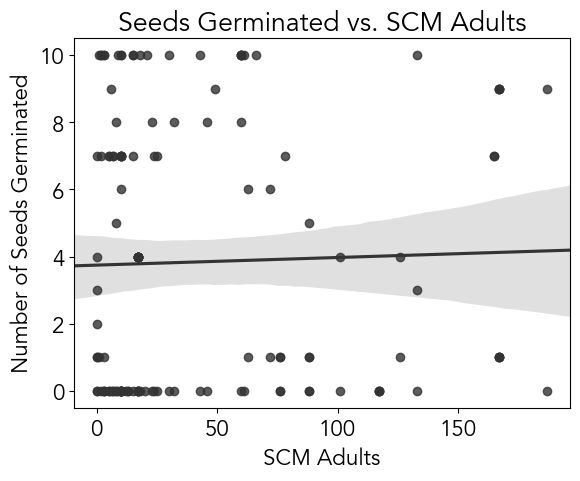

In [ ]:
#ax = sns.stripplot(x = 'total_scm', y = 'nr_seeds_germinated_1st_measure', data=merged_df)

ax = sns.regplot(
    data=merged_df, x="total_scm", y="nr_seeds_germinated_1st_measure",
    scatter=True, truncate=False, order=1, color=".2",
)

#ax.set_xticks(np.arange(0, 200, 10))
#ax.xaxis


plt.xlabel('SCM Adults')
plt.ylabel('Number of Seeds Germinated')
plt.title('Seeds Germinated vs. SCM Adults')


In [ ]:
slope, intercept, r_value, p_value, std_err = stats.linregress(merged_df['total_scm'],merged_df['nr_seeds_germinated_1st_measure'])
slope, intercept, r_value, p_value, std_err

(0.0022687890519388194,
 3.7442058085291876,
 0.029833300793952373,
 0.7292920693957543,
 0.006542331920234958)

In [46]:
merged_df_bean = merged_df.loc[merged_df['Seed Type'] == 'Bean']
merged_df_bean

NameError: name 'merged_df' is not defined

In [45]:
ax = sns.regplot(
    data=merged_df_bean, x="total_scm", y="nr_seeds_germinated_1st_measure",
    scatter=True, truncate=False, order=1, color=".2",
)


plt.xlabel('SCM Adults')
plt.ylabel('Number of Seeds Germinated')
plt.title('Seeds Germinated vs. SCM Adults - Beans')
plt.ylim(-0.5, 10.5)

plt.title('Total Weekly SCM Adults - All Sites', y=1.03)



NameError: name 'merged_df_bean' is not defined

In [ ]:
slope, intercept, r_value, p_value, std_err = stats.linregress(merged_df_bean['total_scm'],merged_df_bean['nr_seeds_germinated_1st_measure'])
slope, intercept, r_value, p_value, std_err

(0.0025987386180030565,
 0.0872760736122975,
 0.3089922211760962,
 0.015393066182379275,
 0.0010413555815668644)

In [42]:
wire_mesh_clean = pd.read_csv('Data/2023_wire_mesh_clean.csv')
df = wire_mesh_clean[['id', 'collection_date', 'record_id']]
df["collection_date"] = pd.to_datetime(
    df["collection_date"], format="%m/%d/%y"
)
df['one_week'] = df["collection_date"] - pd.Timedelta(7, unit="d")
df['two_week'] = df["collection_date"] - pd.Timedelta(14, unit="d")
df

/var/folders/vt/gz9c8wh17772k93xq1vtnl0c0000gn/T/ipykernel_69061/486124964.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["collection_date"] = pd.to_datetime(
/var/folders/vt/gz9c8wh17772k93xq1vtnl0c0000gn/T/ipykernel_69061/486124964.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['one_week'] = df["collection_date"] - pd.Timedelta(7, unit="d")
/var/folders/vt/gz9c8wh17772k93xq1vtnl0c0000gn/T/ipykernel_69061/486124964.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

,id,collection_date,record_id,one_week,two_week
0,37,2023-04-18,POV_DUN,2023-04-11,2023-04-04
1,43,2023-04-18,POV_DUN,2023-04-11,2023-04-04
2,19,2023-04-18,DIP_CUR,2023-04-11,2023-04-04
3,25,2023-04-18,DIP_CUR,2023-04-11,2023-04-04
4,22,2023-04-18,DIP_PAT,2023-04-11,2023-04-04
...,...,...,...,...,...
277,5095,2023-06-12,SMI_KEL,2023-06-05,2023-05-29
278,5033,2023-06-13,SMI_JOH_2,2023-06-06,2023-05-30
279,5101,2023-06-13,SMI_JOH_2,2023-06-06,2023-05-30
280,5041,2023-06-12,SMI_HOL,2023-06-05,2023-05-29


In [43]:
df = df.merge(climate, on='record_id', how='left')
df

,id,collection_date,record_id,one_week,two_week,longitude,latitude,elevation,date,rain_inches,min_temp_f,ave_temp_f,max_temp_f,mean_dew_point,vpd_min,vpd_max,week
0,37,2023-04-18,POV_DUN,2023-04-11,2023-04-04,-76.3992,42.3875,1243.0,2023-01-01,0.02,36.5,43.8,51.1,42.8,0.14,2.87,1.0
1,37,2023-04-18,POV_DUN,2023-04-11,2023-04-04,-76.3992,42.3875,1243.0,2023-01-02,0.00,36.6,39.4,42.2,32.9,0.93,3.12,1.0
2,37,2023-04-18,POV_DUN,2023-04-11,2023-04-04,-76.3992,42.3875,1243.0,2023-01-03,0.00,29.1,38.5,47.9,34.0,0.08,4.35,1.0
3,37,2023-04-18,POV_DUN,2023-04-11,2023-04-04,-76.3992,42.3875,1243.0,2023-01-04,0.51,38.2,45.6,53.0,44.9,0.06,1.44,1.0
4,37,2023-04-18,POV_DUN,2023-04-11,2023-04-04,-76.3992,42.3875,1243.0,2023-01-05,0.21,37.0,46.9,56.7,46.7,0.13,3.47,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100741,5035,2023-06-12,SMI_HOL,2023-06-05,2023-05-29,-74.2978,42.9000,524.0,2023-12-27,0.37,34.5,39.4,44.4,39.6,0.14,1.37,52.0
100742,5035,2023-06-12,SMI_HOL,2023-06-05,2023-05-29,-74.2978,42.9000,524.0,2023-12-28,0.24,41.8,45.4,49.0,43.4,0.27,1.65,52.0
100743,5035,2023-06-12,SMI_HOL,2023-06-05,2023-05-29,-74.2978,42.9000,524.0,2023-12-29,0.09,41.4,44.8,48.2,43.0,0.27,1.31,52.0
100744,5035,2023-06-12,SMI_HOL,2023-06-05,2023-05-29,-74.2978,42.9000,524.0,2023-12-30,0.18,36.3,40.8,45.2,39.0,0.23,1.42,52.0


In [46]:
one_week = df.loc[(df['date'] <= df['collection_date']) & (df['date'] >= df['one_week'])]

one_week_temps = one_week.groupby(['record_id', 'collection_date'], as_index=False).mean()[['record_id', 'collection_date', 'min_temp_f', 'ave_temp_f', 'max_temp_f', 'mean_dew_point', 'vpd_min', 'vpd_max']]
one_week_rain = one_week.groupby(['record_id', 'collection_date'], as_index=False).sum('rain_inches')[['record_id', 'collection_date', 'rain_inches']]
one_week_climate = one_week_temps.merge(one_week_rain, on=['record_id', 'collection_date'])
one_week_climate = one_week_climate.rename(columns={'min_temp_f':'min_temp_f_1_week', 'ave_temp_f':'ave_temp_f_1_week', 'max_temp_f':'max_temp_f_1_week', 'rain_inches':'rain_inches_1_week', 'mean_dew_point':'mean_dew_point_1_week', 'vpd_min':'vpd_min_1_week', 'vpd_max':'vpd_max_1_week'})
one_week_climate.to_csv('Data/2023_wire_mesh_one_week_climate.csv')

In [47]:
two_week = df.loc[(df['date'] <= df['collection_date']) & (df['date'] >= df['two_week'])]

two_week_temps = two_week.groupby(['record_id', 'collection_date'], as_index=False).mean()[['record_id', 'collection_date', 'min_temp_f', 'ave_temp_f', 'max_temp_f', 'mean_dew_point', 'vpd_min', 'vpd_max']]
two_week_rain = two_week.groupby(['record_id', 'collection_date'], as_index=False).sum('rain_inches')[['record_id', 'collection_date', 'rain_inches']]
two_week_climate = two_week_temps.merge(two_week_rain, on=['record_id', 'collection_date'])
two_week_climate = two_week_climate.rename(columns={'min_temp_f':'min_temp_f_2_week', 'ave_temp_f':'ave_temp_f_2_week', 'max_temp_f':'max_temp_f_2_week', 'rain_inches':'rain_inches_2_week', 'mean_dew_point':'mean_dew_point_2_week', 'vpd_min':'vpd_min_2_week', 'vpd_max':'vpd_max_2_week'})
two_week_climate.to_csv('Data/2023_wire_mesh_two_week_climate.csv')

In [9]:
adults = pd.read_csv('Data/2023_scm_counts.csv')
adults = clean_columns(adults)
adults["collection_date"] = pd.to_datetime(adults["collection_date"], format="%m/%d/%y")
#adults["week"] = adults["date"].dt.strftime("%U").astype(int)
adults = adults.drop(['initials'], axis=1)
adults = adults.dropna()
adults = adults.rename({'site':'record_id'}, axis=1)
adults

,card_id,data_collector,record_id,collection_date,n_scm_i_m,n_scm_i_f,n_scm_o_m,n_scm_o_f,n_d_florilega_i,n_d_florilega_o,notes
215,2216,Mike Stanyard,STA_SWE,2023-04-26,10.0,1.0,13.0,0.0,0.0,0.0,Not labeled I or O
2034,7035,Shea Crowther,FLE_FIE_IN,2023-11-07,2.0,4.0,3.0,5.0,3.0,1.0,in field multiple weeks


In [11]:
df = adults[['record_id', 'collection_date']]
df["collection_date"] = pd.to_datetime(
    df["collection_date"], format="%m/%d/%y"
)
df['one_week'] = df["collection_date"] - pd.Timedelta(7, unit="d")
df['two_week'] = df["collection_date"] - pd.Timedelta(14, unit="d")
#df = df.rename({'date':'collection_date'}, axis=1)
df

/var/folders/vt/gz9c8wh17772k93xq1vtnl0c0000gn/T/ipykernel_53998/706485625.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["collection_date"] = pd.to_datetime(
/var/folders/vt/gz9c8wh17772k93xq1vtnl0c0000gn/T/ipykernel_53998/706485625.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['one_week'] = df["collection_date"] - pd.Timedelta(7, unit="d")
/var/folders/vt/gz9c8wh17772k93xq1vtnl0c0000gn/T/ipykernel_53998/706485625.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

,record_id,collection_date,one_week,two_week
215,STA_SWE,2023-04-26,2023-04-19,2023-04-12
2034,FLE_FIE_IN,2023-11-07,2023-10-31,2023-10-24


In [12]:
df = df.merge(climate, on=['record_id'], how='left')

In [13]:
df

,record_id,collection_date,one_week,two_week,longitude,latitude,elevation,date,rain_inches,min_temp_f,ave_temp_f,max_temp_f,mean_dew_point,vpd_min,vpd_max,week
0,STA_SWE,2023-04-26,2023-04-19,2023-04-12,-78.0996,42.7983,1250.0,2023-01-01,0.09,34.9,44.3,53.7,42.5,0.10,3.48,1.0
1,STA_SWE,2023-04-26,2023-04-19,2023-04-12,-78.0996,42.7983,1250.0,2023-01-02,0.09,33.9,37.9,41.9,35.6,0.09,2.25,1.0
2,STA_SWE,2023-04-26,2023-04-19,2023-04-12,-78.0996,42.7983,1250.0,2023-01-03,0.00,34.4,39.8,45.1,36.2,0.18,2.63,1.0
3,STA_SWE,2023-04-26,2023-04-19,2023-04-12,-78.0996,42.7983,1250.0,2023-01-04,0.55,37.6,40.8,44.1,40.4,0.14,0.96,1.0
4,STA_SWE,2023-04-26,2023-04-19,2023-04-12,-78.0996,42.7983,1250.0,2023-01-05,0.66,33.8,42.3,50.7,39.9,0.11,3.09,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,STA_SWE,2023-04-26,2023-04-19,2023-04-12,-78.0996,42.7983,1250.0,2023-12-28,0.49,42.4,46.3,50.2,46.0,0.14,1.15,52.0
362,STA_SWE,2023-04-26,2023-04-19,2023-04-12,-78.0996,42.7983,1250.0,2023-12-29,0.22,38.8,42.8,46.8,42.6,0.08,0.87,52.0
363,STA_SWE,2023-04-26,2023-04-19,2023-04-12,-78.0996,42.7983,1250.0,2023-12-30,0.05,31.9,36.4,40.9,32.0,0.20,2.41,52.0
364,STA_SWE,2023-04-26,2023-04-19,2023-04-12,-78.0996,42.7983,1250.0,2023-12-31,0.04,28.4,30.9,33.5,27.5,0.01,1.33,53.0


In [17]:
df.columns

Index(['record_id', 'collection_date', 'one_week', 'two_week', 'longitude',
       'latitude', 'elevation', 'date', 'rain_inches', 'min_temp_f',
       'ave_temp_f', 'max_temp_f', 'mean_dew_point', 'vpd_min', 'vpd_max',
       'week'],
      dtype='object')

In [19]:
one_week = df.loc[(df['date'] <= df['collection_date']) & (df['date'] >= df['one_week'])]

one_week_temps = one_week.groupby(['record_id', 'collection_date'], as_index=False).mean()[['record_id', 'collection_date', 'min_temp_f', 'ave_temp_f', 'max_temp_f', 'mean_dew_point', 'vpd_min', 'vpd_max']]
one_week_rain = one_week.groupby(['record_id', 'collection_date'], as_index=False).sum('rain_inches')[['record_id', 'collection_date', 'rain_inches']]
one_week_climate = one_week_temps.merge(one_week_rain, on=['record_id', 'collection_date'])
one_week_climate = one_week_climate.rename(columns={'min_temp_f':'min_temp_f_1_week', 'ave_temp_f':'ave_temp_f_1_week', 'max_temp_f':'max_temp_f_1_week', 'rain_inches':'rain_inches_1_week', 'mean_dew_point':'mean_dew_point_1_week', 'vpd_min':'vpd_min_1_week', 'vpd_max':'vpd_max_1_week'})
one_week_climate.to_csv('Data/2023_adults_one_week_climate.csv')

In [20]:
two_week = df.loc[(df['date'] <= df['collection_date']) & (df['date'] >= df['two_week'])]

two_week_temps = two_week.groupby(['record_id', 'collection_date'], as_index=False).mean()[['record_id', 'collection_date', 'min_temp_f', 'ave_temp_f', 'max_temp_f', 'mean_dew_point', 'vpd_min', 'vpd_max']]
two_week_rain = two_week.groupby(['record_id', 'collection_date'], as_index=False).sum('rain_inches')[['record_id', 'collection_date', 'rain_inches']]
two_week_climate = two_week_temps.merge(two_week_rain, on=['record_id', 'collection_date'])
two_week_climate = two_week_climate.rename(columns={'min_temp_f':'min_temp_f_2_week', 'ave_temp_f':'ave_temp_f_2_week', 'max_temp_f':'max_temp_f_2_week', 'rain_inches':'rain_inches_2_week', 'mean_dew_point':'mean_dew_point_2_week', 'vpd_min':'vpd_min_2_week', 'vpd_max':'vpd_max_2_week'})
two_week_climate.to_csv('Data/2023_adults_two_week_climate.csv')

In [29]:
wire_mesh['total_scm'] = wire_mesh['total_scm_maggots'] + wire_mesh['total_scm_pupae']
wire_mesh

,id,container_number,project,seed_type,number_seeds,scm_seeds,other_seeds,total_scm_maggots,total_scm_pupae,number_wireworm,phorid_seeds,total_phorid_maggots,total_phorid_pupae,notes,container_type,collection_date,record_id,total_scm
2,3,3011,R,Bean,8.0,1.0,2.0,1.0,2,0.0,1.0,2.0,3.0,NaN,deli cup,2023-04-17,GAB_ALL,3.0
8,9,3068,R,Bean,8.0,0.0,0.0,0.0,5,1.0,2.0,7.0,9.0,NaN,deli cup,2023-04-18,SMI_JOH_2,5.0
14,15,3010,R,Bean,10.0,0.0,1.0,0.0,0,0.0,0.0,0.0,19.0,NaN,deli cup,2023-04-17,GAB_STE,0.0
20,21,3003,R,Bean,5.0,0.0,1.0,0.0,17,0.0,0.0,0.0,0.0,NaN,deli cup,2023-04-18,DIP_CUR,17.0
29,30,3042,R,Bean,10.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,NaN,deli cup,2023-04-17,SMI_MCC,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824,5085,5100,R,Corn,10.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,NaN,deli cup,2023-06-09,MIL_MCC,0.0
827,5097,5114,R,Corn,10.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,NaN,deli cup,2023-06-12,SMI_KEL,0.0
830,5103,5116,R,Corn,10.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,NaN,deli cup,2023-06-13,SMI_JOH_2,0.0
833,5184,5033,R,Corn,10.0,0.0,3.0,0.0,0,0.0,0.0,0.0,1.0,NaN,deli cup,2023-06-06,DIP_FLE,0.0


In [37]:
df = wire_mesh[['seed_type', 'number_seeds', 'scm_seeds', 'total_scm']]
df['prop_seeds'] = np.round(df['scm_seeds'] / df['number_seeds'], 2)
df['seed_type'].replace('Bean', 'Lima Bean', inplace=True)
df

/var/folders/vt/gz9c8wh17772k93xq1vtnl0c0000gn/T/ipykernel_5841/33307427.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prop_seeds'] = np.round(df['scm_seeds'] / df['number_seeds'], 2)
/var/folders/vt/gz9c8wh17772k93xq1vtnl0c0000gn/T/ipykernel_5841/33307427.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['seed_type'].replace('Bean', 'Lima Bean', inplace=True)


,seed_type,number_seeds,scm_seeds,total_scm,prop_seeds
2,Lima Bean,8.0,1.0,3.0,0.12
8,Lima Bean,8.0,0.0,5.0,0.00
14,Lima Bean,10.0,0.0,0.0,0.00
20,Lima Bean,5.0,0.0,17.0,0.00
29,Lima Bean,10.0,0.0,1.0,0.00
...,...,...,...,...,...
824,Corn,10.0,0.0,0.0,0.00
827,Corn,10.0,0.0,0.0,0.00
830,Corn,10.0,0.0,0.0,0.00
833,Corn,10.0,0.0,0.0,0.00


/Users/chloecho/anaconda3/envs/cornell_dev/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chloecho/anaconda3/envs/cornell_dev/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chloecho/anaconda3/envs/cornell_dev/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


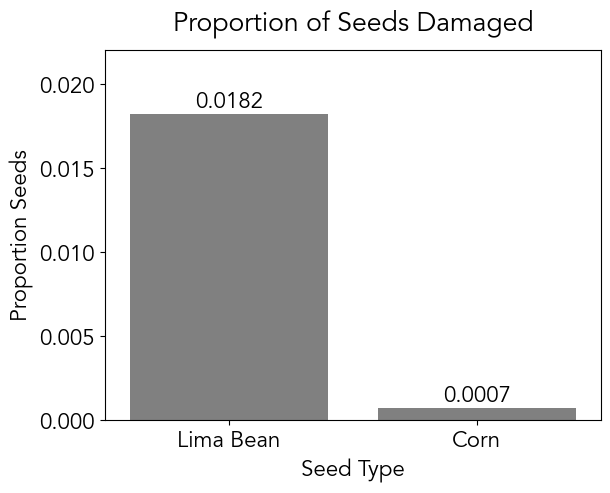

In [38]:
plt.rcParams['font.sans-serif'] = ['Avenir']
plt.rcParams.update({'font.size': 16})

ax = sns.barplot(x = 'seed_type', y = 'prop_seeds', data = df, color='grey', errorbar=None)
ax.set(xlabel='Seed Type', ylabel='Proportion Seeds')

ax.set_ylim(0, 0.022)
plt.title('Proportion of Seeds Damaged', y=1.03)

for i in ax.containers:
    ax.bar_label(i, fmt='%.4f')


/Users/chloecho/anaconda3/envs/cornell_dev/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chloecho/anaconda3/envs/cornell_dev/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chloecho/anaconda3/envs/cornell_dev/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


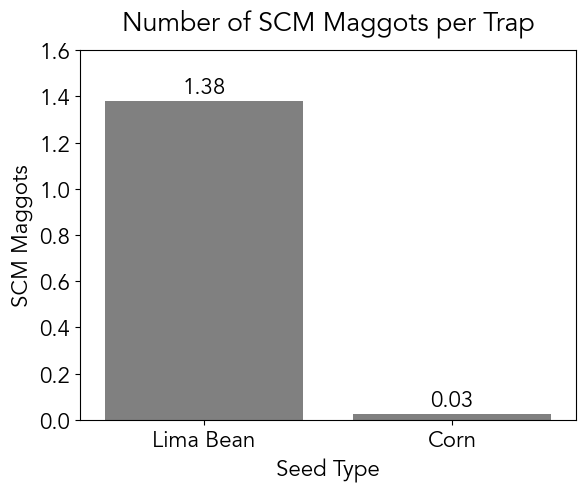

In [39]:
plt.rcParams['font.sans-serif'] = ['Avenir']
plt.rcParams.update({'font.size': 16})

ax = sns.barplot(x = 'seed_type', y = 'total_scm', data = df, color='grey', errorbar=None)
ax.set(xlabel='Seed Type', ylabel='SCM Maggots')

ax.set_ylim(0, 1.6)
plt.title('Number of SCM Maggots per Trap', y=1.03)

for i in ax.containers:
    ax.bar_label(i,fmt='%.2f')

In [78]:
df

,seed_type,number_seeds,scm_seeds,total_scm,prop_seeds
2,Bean,8.0,1.0,3.0,0.125
8,Bean,8.0,0.0,5.0,0.000
14,Bean,10.0,0.0,0.0,0.000
20,Bean,5.0,0.0,17.0,0.000
29,Bean,10.0,0.0,1.0,0.000
...,...,...,...,...,...
824,Corn,10.0,0.0,0.0,0.000
827,Corn,10.0,0.0,0.0,0.000
830,Corn,10.0,0.0,0.0,0.000
833,Corn,10.0,0.0,0.0,0.000


In [90]:
len(df.loc[(df['total_scm'] >= 5) & (df['seed_type'] == 'Bean')])

11

In [88]:
sum(df['total_scm'])

196.0